In [1]:

import pandas as pd 
import numpy as np 
from collections import defaultdict
import pyreadstat
from datetime import datetime
from scipy import stats

pd.set_option('display.max_columns', None)

In [2]:
w1_base = pd.read_spss('./datenstze/W1_PPS_02.sav')
# w2 = pd.read_spss('./datenstze/W2_PPS_01.sav')
w3_base = pd.read_spss('./datenstze/W3_PPS_Datensatz01.sav')
w4_base = pd.read_spss('./datenstze/W4_PPS_SoSe21_v1.sav')
w5_base = pd.read_spss('./datenstze/W5_PPS_02.sav')

## Files
# 1. './datenstze/Welle6_v2_4_Gruppen.sav'
# 2. './datenstze/Welle6_v3_Gruppen.sav'
w6_base = pd.read_spss('./datenstze/Welle6_v3_Gruppen.sav')
# w8 = pd.read_spss('./datenstze/Welle8_v2.sav')


In [3]:
# Helper functions

def define_praktikums(row, tuples, returnList=False):
    list_praktikums = []
    for (col, praktikum) in tuples:
        if(row[col] == 'ausgewählt' or row[col] == 'Praktikum absolviert'):
            list_praktikums.append(praktikum)
    if returnList:
        return list_praktikums
    if len(list_praktikums) > 0:
        return list_praktikums[-1]
    else:
        return None

In [4]:
praktikums_names = {
    "Einführungspraktikum A": "EP A",
    "Einführungspraktikum B": "EP B",
    "Fachpraktikum A": "FP A", 
    "Fachpraktikum B": "FP B",
    "Vertiefungspraktikum A": "VP A", 
    "Vertiefungspraktikum B": "VP B", 
}

# Relation column name, and praktikum

praktikums_w1 = [
    ('D6_01','FP A'),
    ('D6_02','FP B'),
    ('D6_03','VP A'),
    ('D6_04','VP B')
    ]

praktikums_w2 = [
    ('SD23_01','FP A'),
    ('SD23_02','FP B'),
    ('SD23_03','VP A'),
    ('SD23_04','VP B')
    ]

praktikums_w3 = [
    ('PS11_01','FP A'),
    ('PS11_02','FP B'),
    ('PS11_03','VP A'),
    ('PS11_04','VP B'),
    ('PS11_05','EP A')]

praktikums_w4 = [
    ('PS11_01','FP A'),
    ('PS11_02','FP B'),
    ('PS11_03','VP A'),
    ('PS11_04','VP B'),
    ('PS11_05','EP B')
    ]

praktikums_w8 = [
    ('SD08_01','EP A'),
    ('SD08_02','EP B'),
    ('SD08_03','FP A'),
    ('SD08_04','FP B'), 
    ('SD08_05','VP A'),
    ('SD08_06','VP B'),
    ('SD08_07','MP A')
    ]

w1_base['Praktikum'] = w1_base.apply(lambda row: define_praktikums(row, praktikums_w1, returnList=False), axis=1)
w3_base['Praktikum'] = w3_base.apply(lambda row: define_praktikums(row, praktikums_w3, returnList=False), axis=1)
w4_base['Praktikum'] = w4_base.apply(lambda row: define_praktikums(row, praktikums_w4, returnList=False), axis=1)

w5_base['Praktikum'] = w5_base['PS11']
w5_base['Praktikum'].replace(praktikums_names, inplace=True)

w6_base['Praktikum'] = w6_base['PS11']
w6_base['Praktikum'].replace(praktikums_names, inplace=True)


In [5]:
# Generate ID of students

# Code is [VornameMutter] + [VornameVater] + [ErsteBuchstabe Vorname Student] + [Tag Geburstag] + [(G: grün, B: blue, B: brown) * (ignoring)]
# w2['ID_student'] = w2['ID01_01'] +w2['ID01_03'] + w2['ID01_05'] + w2['ID01_07'].str.zfill(2)
w3_base['ID_student'] = w3_base['CV27_01'].str[:5]
w4_base['ID_student'] = w4_base['CV27_01'] +w4_base['CV27_02'] + w4_base['CV27_03'] + w4_base['CV27_04'].astype('str').str.zfill(2)
w5_base['ID_student'] = w5_base['CV27_01'] +w5_base['CV27_02'] + w5_base['CV27_03'] + w5_base['CV27_04'].astype('str').str.zfill(2)
w6_base['ID_student'] = w6_base['SC08_01'] +w6_base['SC08_02'] + w6_base['SC08_03'] + w6_base['SC08_04'].astype('str').str.zfill(2)
# w8['ID_student'] = w8['CO01_01'].str[:5]


# Assign welle name

w1_base["Welle"] = 1
w3_base["Welle"] = 3
w4_base["Welle"] = 4
w5_base["Welle"] = 5
w6_base["Welle"] = 6

In [6]:

# w3 PS10 Finished
# w4 PS10 Finished
# w5 PS10 Finished
# w6 PS10 Finished
# w8 SD09 Finished, SD04 -> Remove ( 2 = Master Lehramt Sekundarstufe (All-gemeinbildung)  &&  3 = HLG Querein-stieg)


### Selection and renaming of relevant columns

In [7]:
# w1    --> D5   Semester;                                     "B1_01   (F_01)";           "B8_04   (F_03)";           "B7_01   (F_09);           B1_02   (F_11)" #
# w3,w4 --> PS13 Semester;                                     "PP01_01 (F_01)";           "PP05_04 (F_03)";           "PP05_05 (F_09);           PP01_02 (F_11)" #
# w5    --> PS13 Semester, Beginn des Studium;                 "PP01_01 (F_01)";           "BP01_06 (F_03)";           "BP01_01 (F_09);           PP01_02 (F_11)" #
# w6    --> SF02 Semester, Beginn des Studium;                 "PP01_01 (F_01)";           "BP01_06 (F_03)";           "BP01_01 (F_09);           PP09_01 (F_11)" #
# w8    --> SD05 Semester, Beginn des Studium;                 "PP01_01 (F_01)";           "PP02_05 (F_03)";           "PP02_01 (F_09);           PP01_05 (F_11)" #

#  ----------  W1 -------------

W1_BASE_COLUMS = [
    'D1', 'D2','D3_01','D3_02','D4_01','D4_02','D5', 'D7_01', 'D7_02', 'S1', 'S2', 'S3', 'S4', 'S5', 'B1_01', 'B8_04', 'B7_03', 'B1_02', 
     # LG_B
    'L1_01','L1_02','L1_03','L1_04','L1_05','L1_06','L1_07','L1_08','L1_09',
     # LG_VP_PD ---> Join (LG_VP_PD + LG_FP_PD ) = LG_FVP_PD 
    'VP_L01','VP_L02','VP_L03','VP_L04','VP_L05','VP_L06','VP_L07','VP_L08','VP_L09','VP_L10','VP_L11','VP_L12','VP_L13','VP_L14','VP_L15','VP_L17','VP_L18','VP_L19','VP_L20','VP_L21','VP_L22','VP_L23','VP_L24',
    'VP_L25','VP_L26','VP_L27','VP_L28','VP_L29','VP_L30','VP_L31','VP_L32','VP_L33','VP_L34','VP_L35','VP_L36','VP_L37','VP_L38','VP_L39','VP_L40','VP_L41','VP_L42',
     # LG_FP_PD ---> Join (LG_VP_PD + LG_FP_PD ) = LG_FVP_PD 
    'FP_L01','FP_L02','FP_L03','FP_L04','FP_L05','FP_L06','FP_L07','FP_L08','FP_L09','FP_L10','FP_L11','FP_L12','FP_L13','FP_L14','FP_L15','FP_L16','FP_L17','FP_L18','FP_L19','FP_L20','FP_L21','FP_L22','FP_L23','FP_L24',
    'FP_L25','FP_L26','FP_L27','FP_L28','FP_L29','FP_L30','FP_L31','FP_L32','FP_L33',
     # RE_VP    ---> Join (RE_VP + RE_FP ) = LG_FVP_RE 
    'VP_L50', 'VP_L51', 'VP_L52', 'VP_L53', 'VP_L54', 'VP_L55', 'VP_L56',
     # RE_FP    ---> Join (RE_VP + RE_FP ) = LG_FVP_RE 
    'FP_L50', 'FP_L51', 'FP_L52', 'FP_L53', 'FP_L54', 'FP_L55', 'FP_L56',
    # NEW
    'FINISHED', 'TIME_SUM', 'SWE_Ges', 'Welle', 'Praktikum'
    ]
w1 = w1_base[W1_BASE_COLUMS].copy()

# ADD P_Absolviert in W1, consider that all finished the praktikum
w1['P_Absolviert'] = 'ja'

w1_common = {
    "D1": "alter", 
    "D2": "geschlecht", #  0 - m ; 1 - f ; 2 - diverse
    'D3_01' : 'Imp_FachA', # Range (1 - 7)
    'D3_02' : 'Imp_FachB',
    'D4_01' : 'FachA',
    'D4_02' : 'FachB',
    'D5': 'Semester',
    'D7_01' : 'Schultyp_A', # (NMS,1) , (Poly,2), (ASO,3), (AHS,4), (BMHS,5)
    'D7_02' : 'Schultyp_B',
    'S1' : 'SWE_01',
    'S2' : 'SWE_02',
    'S3' : 'SWE_03',
    'S4' : 'SWE_04',
    'S5' : 'SWE_05',
    'SWE_Ges' : 'SWE',
    'B1_01' : 'F_01', 
    'B8_04' : 'F_03', 
    'B7_03' : 'F_09',  
    'B1_02' : 'F_11',
    # LG_B
    'L1_01' : 'LG_B_01', 'L1_02' : 'LG_B_02', 'L1_03' : 'LG_B_03', 
    'L1_04' : 'LG_B_04', 'L1_05' : 'LG_B_05', 'L1_06' : 'LG_B_06', 
    'L1_07' : 'LG_B_07', 'L1_08' : 'LG_B_08', 'L1_09' : 'LG_B_09',
     # LG_VP_PD ---> Join (LG_VP_PD + LG_FP_PD ) = LG_FVP_PD 
    'VP_L01': 'LG_VP_PD_01', 'VP_L02': 'LG_VP_PD_02', 'VP_L03': 'LG_VP_PD_03',
    'VP_L04': 'LG_VP_PD_04', 'VP_L05': 'LG_VP_PD_05', 'VP_L06': 'LG_VP_PD_06', 
    'VP_L07': 'LG_VP_PD_07', 'VP_L08': 'LG_VP_PD_08', 'VP_L09': 'LG_VP_PD_09', 
    'VP_L10': 'LG_VP_PD_10', 'VP_L11': 'LG_VP_PD_11', 'VP_L12': 'LG_VP_PD_12', 
    'VP_L13': 'LG_VP_PD_13', 'VP_L14': 'LG_VP_PD_14', 'VP_L15': 'LG_VP_PD_15', 
    'VP_L17': 'LG_VP_PD_17', 'VP_L18': 'LG_VP_PD_18', 
    'VP_L19': 'LG_VP_PD_19', 'VP_L20': 'LG_VP_PD_20', 'VP_L21': 'LG_VP_PD_21', 
    'VP_L22': 'LG_VP_PD_22', 'VP_L23': 'LG_VP_PD_23', 'VP_L24': 'LG_VP_PD_24', 
    'VP_L25': 'LG_VP_PD_25', 'VP_L26': 'LG_VP_PD_26', 'VP_L27': 'LG_VP_PD_27', 
    'VP_L28': 'LG_VP_PD_28', 'VP_L29': 'LG_VP_PD_29', 'VP_L30': 'LG_VP_PD_30', 
    'VP_L31': 'LG_VP_PD_31', 'VP_L32': 'LG_VP_PD_32', 'VP_L33': 'LG_VP_PD_33', 
    'VP_L34': 'LG_VP_PD_34', 'VP_L35': 'LG_VP_PD_35', 'VP_L36': 'LG_VP_PD_36', 
    'VP_L37': 'LG_VP_PD_37', 'VP_L38': 'LG_VP_PD_38', 'VP_L39': 'LG_VP_PD_39', 
    'VP_L40': 'LG_VP_PD_40', 'VP_L41': 'LG_VP_PD_41', 'VP_L42': 'LG_VP_PD_42',
     # LG_FP_PD ---> Join (LG_VP_PD + LG_FP_PD ) = LG_FVP_PD 
    'FP_L01' : 'LG_FP_PD_01', 'FP_L02' : 'LG_FP_PD_02', 'FP_L03' : 'LG_FP_PD_03', 
    'FP_L04' : 'LG_FP_PD_04', 'FP_L05' : 'LG_FP_PD_05', 'FP_L06' : 'LG_FP_PD_06', 
    'FP_L07' : 'LG_FP_PD_07', 'FP_L08' : 'LG_FP_PD_08', 'FP_L09' : 'LG_FP_PD_09', 
    'FP_L10' : 'LG_FP_PD_10', 'FP_L11' : 'LG_FP_PD_11', 'FP_L12' : 'LG_FP_PD_12', 
    'FP_L13' : 'LG_FP_PD_13', 'FP_L14' : 'LG_FP_PD_14', 'FP_L15' : 'LG_FP_PD_15', 
    'FP_L16' : 'LG_FP_PD_16', 'FP_L17' : 'LG_FP_PD_17', 'FP_L18' : 'LG_FP_PD_18', 
    'FP_L19' : 'LG_FP_PD_19', 'FP_L20' : 'LG_FP_PD_20', 'FP_L21' : 'LG_FP_PD_21', 
    'FP_L22' : 'LG_FP_PD_22', 'FP_L23' : 'LG_FP_PD_23', 'FP_L24' : 'LG_FP_PD_24', 
    'FP_L25' : 'LG_FP_PD_25', 'FP_L26' : 'LG_FP_PD_26', 'FP_L27' : 'LG_FP_PD_27', 
    'FP_L28' : 'LG_FP_PD_28', 'FP_L29' : 'LG_FP_PD_29', 'FP_L30' : 'LG_FP_PD_30', 
    'FP_L31' : 'LG_FP_PD_31', 'FP_L32' : 'LG_FP_PD_32', 'FP_L33' : 'LG_FP_PD_33',
     # LG_RE_VP    ---> Join (RE_VP + RE_FP ) = LG_FVP_RE 
    'VP_L50' : 'LG_RE_VP_01', 'VP_L51' : 'LG_RE_VP_02', 'VP_L52' : 'LG_RE_VP_03', 
    'VP_L53' : 'LG_RE_VP_04', 'VP_L54' : 'LG_RE_VP_05', 'VP_L55' : 'LG_RE_VP_06', 
    'VP_L56' : 'LG_RE_VP_07',
     # LG_RE_FP    ---> Join (RE_VP + RE_FP ) = LG_FVP_RE 
    'FP_L50' : 'LG_RE_FP_01', 'FP_L51' : 'LG_RE_FP_02', 'FP_L52' : 'LG_RE_FP_03', 
    'FP_L53' : 'LG_RE_FP_04', 'FP_L54' : 'LG_RE_FP_05', 'FP_L55' : 'LG_RE_FP_06', 
    'FP_L56' : 'LG_RE_FP_07',
}
w1.rename(columns={ **w1_common}, inplace=True)


#  ----------  W3 -------------

W3_BASE_COLUMS = [
    'D001_01', 'D002', 'PS17_01', 'PS17_02', 'PS15', 'PS14', 'PS13', 'PS10', 'PS03', 'KO01_01','KO01_02','KO01_03', 'KO01_04','KO01_05', 'PP01_01', 'PP05_04', 'PP05_05', 'PP01_02', 
     # LG_B
    'LG01_01','LG01_02','LG01_03','LG01_04','LG01_05','LG01_06','LG01_07','LG01_08','LG01_09','LG01_10',
     # LG_VP_PD ---> Join (LG_VP_PD + LG_FP_PD ) = LG_FVP_PD 
    'VP01_01','VP01_02','VP01_03','VP01_04','VP01_05','VP01_06','VP01_07','VP01_08','VP01_09','VP01_10','VP01_11','VP01_12','VP01_13','VP01_14',
    'VP02_01','VP02_02','VP02_03','VP02_04','VP02_05','VP02_06','VP02_07','VP02_08','VP02_09','VP02_10','VP02_11','VP02_12',
    'VP03_01','VP03_03','VP03_04','VP03_05','VP03_06','VP03_07','VP03_08','VP03_09','VP03_10','VP03_11','VP03_12','VP03_13','VP03_14','VP03_15','VP03_16',
     # LG_RE_VP    ---> Join (RE_VP + RE_FP ) = LG_FVP_RE 
    'VP04_01', 'VP04_02', 'VP04_03', 'VP04_04','VP04_05', 'VP04_06', 'VP04_07',
     # LG_FP_PD ---> Join (LG_VP_PD + LG_FP_PD ) = LG_FVP_PD 
    'FP01_01','FP01_02','FP01_03','FP01_04','FP01_05','FP01_06','FP01_07','FP01_08','FP01_09','FP01_10','FP01_11','FP01_12','FP01_13',
    'FP02_01','FP02_02','FP02_03','FP02_04','FP02_05','FP02_06','FP02_07','FP02_08','FP02_09','FP02_10','FP02_11','FP02_12','FP02_13','FP02_14','FP02_15','FP02_16','FP02_17','FP02_18','FP02_19','FP02_20',
     # LG_RE_FP    ---> Join (RE_VP + RE_FP ) = LG_FVP_RE 
    'FP03_01', 'FP03_02', 'FP03_03', 'FP03_04', 'FP03_05', 'FP03_06', 'FP03_07',
    # NEW
    'FINISHED', 'TIME_SUM', 'Welle', 'Praktikum'
    ]

w3 = w3_base[W3_BASE_COLUMS].copy()

w3_common =  {
    "D001_01" : "alter",
    "D002" : "geschlecht", 
    'PS17_01' : 'Imp_FachA', 
    'PS17_02' : 'Imp_FachB', 
    'PS15' : 'FachA', 
    'PS14' : 'FachB', 
    'PS13' : 'Semester', 
    'PS10' : 'P_Absolviert', 
    'PS03' : 'Schultyp_A', 
    'KO01_01' : 'SWE_01', 'KO01_02' : 'SWE_02', 'KO01_03' : 'SWE_03',  'KO01_04' : 'SWE_04', 'KO01_05' : 'SWE_05',
    'PP01_01' : 'F_01', 
    'PP05_04' : 'F_03', 
    'PP05_05' : 'F_09', 
    'PP01_02' : 'F_11', 
    # LG_B
    'LG01_01' : 'LG_B_01', 'LG01_02' : 'LG_B_02', 'LG01_03' : 'LG_B_03', 
    'LG01_04' : 'LG_B_04', 'LG01_05' : 'LG_B_05', 'LG01_06' : 'LG_B_06', 
    'LG01_07' : 'LG_B_07', 'LG01_08' : 'LG_B_08', 'LG01_09' : 'LG_B_09', 
    'LG01_10' : 'LG_B_10',
     # LG_VP_PD ---> Join (LG_VP_PD + LG_FP_PD ) = LG_FVP_PD 
    'VP01_01' : 'LG_VP_PD_01', 'VP01_02' : 'LG_VP_PD_02', 'VP01_03' : 'LG_VP_PD_03', 
    'VP01_04' : 'LG_VP_PD_04', 'VP01_05' : 'LG_VP_PD_05', 'VP01_06' : 'LG_VP_PD_06', 
    'VP01_07' : 'LG_VP_PD_07', 'VP01_08' : 'LG_VP_PD_08', 'VP01_09' : 'LG_VP_PD_09', 
    'VP01_10' : 'LG_VP_PD_10', 'VP01_11' : 'LG_VP_PD_11', 'VP01_12' : 'LG_VP_PD_12', 
    'VP01_13' : 'LG_VP_PD_13', 'VP01_14' : 'LG_VP_PD_14', 'VP02_01' : 'LG_VP_PD_15', 
    'VP02_02' : 'LG_VP_PD_16', 'VP02_03' : 'LG_VP_PD_17', 'VP02_04' : 'LG_VP_PD_18', 
    'VP02_05' : 'LG_VP_PD_19', 'VP02_06' : 'LG_VP_PD_20', 'VP02_07' : 'LG_VP_PD_21', 
    'VP02_08' : 'LG_VP_PD_22', 'VP02_09' : 'LG_VP_PD_23', 'VP02_10' : 'LG_VP_PD_24', 
    'VP02_11' : 'LG_VP_PD_25', 'VP02_12' : 'LG_VP_PD_26', 'VP03_01' : 'LG_VP_PD_27', 
    'VP03_03' : 'LG_VP_PD_29', 'VP03_04' : 'LG_VP_PD_30', 
    'VP03_05' : 'LG_VP_PD_31', 'VP03_06' : 'LG_VP_PD_32', 'VP03_07' : 'LG_VP_PD_33', 
    'VP03_08' : 'LG_VP_PD_34', 'VP03_09' : 'LG_VP_PD_35', 'VP03_10' : 'LG_VP_PD_36', 
    'VP03_11' : 'LG_VP_PD_37', 'VP03_12' : 'LG_VP_PD_38', 'VP03_13' : 'LG_VP_PD_39', 
    'VP03_14' : 'LG_VP_PD_40', 'VP03_15' : 'LG_VP_PD_41', 'VP03_16' : 'LG_VP_PD_42',
     # LG_RE_VP    ---> Join (RE_VP + RE_FP ) = LG_FVP_RE 
    'VP04_01' : 'LG_RE_VP_01', 'VP04_02' : 'LG_RE_VP_02', 'VP04_03' : 'LG_RE_VP_03', 
    'VP04_04' : 'LG_RE_VP_04', 'VP04_05' : 'LG_RE_VP_05', 'VP04_06' : 'LG_RE_VP_06', 
    'VP04_07' : 'LG_RE_VP_07',
     # LG_FP_PD ---> Join (LG_VP_PD + LG_FP_PD ) = LG_FVP_PD 
    'FP01_01' : 'LG_FP_PD_01', 'FP01_02' : 'LG_FP_PD_02', 'FP01_03' : 'LG_FP_PD_03', 
    'FP01_04' : 'LG_FP_PD_04', 'FP01_05' : 'LG_FP_PD_05', 'FP01_06' : 'LG_FP_PD_06', 
    'FP01_07' : 'LG_FP_PD_07', 'FP01_08' : 'LG_FP_PD_08', 'FP01_09' : 'LG_FP_PD_09', 
    'FP01_10' : 'LG_FP_PD_10', 'FP01_11' : 'LG_FP_PD_11', 'FP01_12' : 'LG_FP_PD_12', 
    'FP01_13' : 'LG_FP_PD_13', 'FP02_01' : 'LG_FP_PD_14', 'FP02_02' : 'LG_FP_PD_15', 
    'FP02_03' : 'LG_FP_PD_16', 'FP02_04' : 'LG_FP_PD_17', 'FP02_05' : 'LG_FP_PD_18', 
    'FP02_06' : 'LG_FP_PD_19', 'FP02_07' : 'LG_FP_PD_20', 'FP02_08' : 'LG_FP_PD_21', 
    'FP02_09' : 'LG_FP_PD_22', 'FP02_10' : 'LG_FP_PD_23', 'FP02_11' : 'LG_FP_PD_24', 
    'FP02_12' : 'LG_FP_PD_25', 'FP02_13' : 'LG_FP_PD_26', 'FP02_14' : 'LG_FP_PD_27', 
    'FP02_15' : 'LG_FP_PD_28', 'FP02_16' : 'LG_FP_PD_29', 'FP02_17' : 'LG_FP_PD_30', 
    'FP02_18' : 'LG_FP_PD_31', 'FP02_19' : 'LG_FP_PD_32', 'FP02_20' : 'LG_FP_PD_33',
     # LG_RE_FP    ---> Join (RE_VP + RE_FP ) = LG_FVP_RE 
    'FP03_01' : 'LG_RE_FP_01', 'FP03_02' : 'LG_RE_FP_02', 'FP03_03' : 'LG_RE_FP_03', 
    'FP03_04' : 'LG_RE_FP_04', 'FP03_05' : 'LG_RE_FP_05', 'FP03_06' : 'LG_RE_FP_06', 
    'FP03_07' : 'LG_RE_FP_07',
}

w3.rename(columns={**w3_common,}, inplace=True)

#  ----------  W4 -------------

W4_BASE_COLUMS = [
    'D001_01', 'D002', 'PS17_01', 'PS17_02', 'PS15', 'PS14', 'PS13', 'PS10', 'PS04_01', 'PS19_01', 'PS20_01', 'PS03', 'KO01_01','KO01_02','KO01_03', 'KO01_04','KO01_05', 'PP01_01', 'PP05_04', 'PP05_05', 'PP01_02',
    # LG_B
    'LG01_01','LG01_02','LG01_03','LG01_04','LG01_05','LG01_06','LG01_07','LG01_08','LG01_09','LG01_10',
     # LG_VP_PD ---> Join (LG_VP_PD + LG_FP_PD ) = LG_FVP_PD 
    'VP01_01','VP01_02','VP01_03','VP01_04','VP01_05','VP01_06','VP01_07','VP01_08','VP01_09','VP01_10','VP01_11','VP01_12','VP01_13','VP01_14',
    'VP02_01','VP02_02','VP02_03','VP02_04','VP02_05','VP02_06','VP02_07','VP02_08','VP02_09','VP02_10','VP02_11','VP02_12',
    'VP03_01','VP03_02','VP03_03','VP03_04','VP03_05','VP03_06','VP03_07','VP03_08','VP03_09','VP03_10','VP03_11','VP03_12','VP03_13','VP03_14','VP03_15','VP03_16',
    # RE_VP    ---> Join (RE_VP + RE_FP ) = LG_FVP_RE 
    'VP04_01', 'VP04_02', 'VP04_03', 'VP04_04','VP04_05', 'VP04_06', 'VP04_07',
     # LG_FP_PD ---> Join (LG_VP_PD + LG_FP_PD ) = LG_FVP_PD 
    'FP01_01','FP01_02','FP01_03','FP01_04','FP01_05','FP01_06','FP01_07','FP01_08','FP01_09','FP01_10','FP01_11','FP01_12','FP01_13',
    'FP02_01','FP02_02','FP02_03','FP02_04','FP02_05','FP02_06','FP02_07','FP02_08','FP02_09','FP02_10','FP02_11','FP02_12','FP02_13','FP02_14','FP02_15','FP02_16','FP02_17','FP02_18','FP02_19','FP02_20',
    # RE_FP    ---> Join (RE_VP + RE_FP ) = LG_FVP_RE 
    'FP03_01', 'FP03_02', 'FP03_03', 'FP03_04', 'FP03_05', 'FP03_06', 'FP03_07',
    # NEW
    'FINISHED', 'TIME_SUM', 'Welle', 'Praktikum'
]

w4 = w4_base[W4_BASE_COLUMS].copy()


w4_common = {
    "D001_01": "alter",
    "D002": "geschlecht",
    'PS17_01' : 'Imp_FachA', 
    'PS17_02' : 'Imp_FachB', 
    'PS15' : 'FachA', 
    'PS14' : 'FachB', 
    'PS13' : 'Semester', 
    'PS10' : 'P_Absolviert',
    'PS04_01' : 'H_PP',
    'PS19_01' : 'H_B',
    'PS20_01' : 'H_U',
    'PS03' : 'Schultyp_A',
    'KO01_01' : 'SWE_01', 'KO01_02' : 'SWE_02', 'KO01_03' : 'SWE_03',  'KO01_04' : 'SWE_04', 'KO01_05' : 'SWE_05',
    'PP01_01' : 'F_01', 
    'PP05_04': 'F_03', 
    'PP05_05': 'F_09', 
    'PP01_02': 'F_11', 
    # LG_B
    'LG01_01' : 'LG_B_01', 'LG01_02' : 'LG_B_02', 'LG01_03' : 'LG_B_03', 
    'LG01_04' : 'LG_B_04', 'LG01_05' : 'LG_B_05', 'LG01_06' : 'LG_B_06', 
    'LG01_07' : 'LG_B_07', 'LG01_08' : 'LG_B_08', 'LG01_09' : 'LG_B_09', 
    'LG01_10' : 'LG_B_10',
     # LG_VP_PD ---> Join (LG_VP_PD + LG_FP_PD ) = LG_FVP_PD 
    'VP01_01' : 'LG_VP_PD_01', 'VP01_02' : 'LG_VP_PD_02', 'VP01_03' : 'LG_VP_PD_03', 
    'VP01_04' : 'LG_VP_PD_04', 'VP01_05' : 'LG_VP_PD_05', 'VP01_06' : 'LG_VP_PD_06', 
    'VP01_07' : 'LG_VP_PD_07', 'VP01_08' : 'LG_VP_PD_08', 'VP01_09' : 'LG_VP_PD_09', 
    'VP01_10' : 'LG_VP_PD_10', 'VP01_11' : 'LG_VP_PD_11', 'VP01_12' : 'LG_VP_PD_12', 
    'VP01_13' : 'LG_VP_PD_13', 'VP01_14' : 'LG_VP_PD_14', 'VP02_01' : 'LG_VP_PD_15', 
    'VP02_02' : 'LG_VP_PD_16', 'VP02_03' : 'LG_VP_PD_17', 'VP02_04' : 'LG_VP_PD_18', 
    'VP02_05' : 'LG_VP_PD_19', 'VP02_06' : 'LG_VP_PD_20', 'VP02_07' : 'LG_VP_PD_21', 
    'VP02_08' : 'LG_VP_PD_22', 'VP02_09' : 'LG_VP_PD_23', 'VP02_10' : 'LG_VP_PD_24', 
    'VP02_11' : 'LG_VP_PD_25', 'VP02_12' : 'LG_VP_PD_26', 'VP03_01' : 'LG_VP_PD_27', 
    'VP03_03' : 'LG_VP_PD_29', 'VP03_04' : 'LG_VP_PD_30', 
    'VP03_05' : 'LG_VP_PD_31', 'VP03_06' : 'LG_VP_PD_32', 'VP03_07' : 'LG_VP_PD_33', 
    'VP03_08' : 'LG_VP_PD_34', 'VP03_09' : 'LG_VP_PD_35', 'VP03_10' : 'LG_VP_PD_36', 
    'VP03_11' : 'LG_VP_PD_37', 'VP03_12' : 'LG_VP_PD_38', 'VP03_13' : 'LG_VP_PD_39', 
    'VP03_14' : 'LG_VP_PD_40', 'VP03_15' : 'LG_VP_PD_41', 'VP03_16' : 'LG_VP_PD_42',
      # LG_RE_VP    ---> Join (RE_VP + RE_FP ) = LG_FVP_RE 
    'VP04_01' : 'LG_RE_VP_01', 'VP04_02' : 'LG_RE_VP_02', 'VP04_03' : 'LG_RE_VP_03', 
    'VP04_04' : 'LG_RE_VP_04', 'VP04_05' : 'LG_RE_VP_05', 'VP04_06' : 'LG_RE_VP_06',
    'VP04_07' : 'LG_RE_VP_07',
     # LG_FP_PD ---> Join (LG_VP_PD + LG_FP_PD ) = LG_FVP_PD 
    'FP01_01' : 'LG_FP_PD_01', 'FP01_02' : 'LG_FP_PD_02', 'FP01_03' : 'LG_FP_PD_03', 
    'FP01_04' : 'LG_FP_PD_04', 'FP01_05' : 'LG_FP_PD_05', 'FP01_06' : 'LG_FP_PD_06', 
    'FP01_07' : 'LG_FP_PD_07', 'FP01_08' : 'LG_FP_PD_08', 'FP01_09' : 'LG_FP_PD_09', 
    'FP01_10' : 'LG_FP_PD_10', 'FP01_11' : 'LG_FP_PD_11', 'FP01_12' : 'LG_FP_PD_12', 
    'FP01_13' : 'LG_FP_PD_13', 'FP02_01' : 'LG_FP_PD_14', 'FP02_02' : 'LG_FP_PD_15', 
    'FP02_03' : 'LG_FP_PD_16', 'FP02_04' : 'LG_FP_PD_17', 'FP02_05' : 'LG_FP_PD_18', 
    'FP02_06' : 'LG_FP_PD_19', 'FP02_07' : 'LG_FP_PD_20', 'FP02_08' : 'LG_FP_PD_21', 
    'FP02_09' : 'LG_FP_PD_22', 'FP02_10' : 'LG_FP_PD_23', 'FP02_11' : 'LG_FP_PD_24', 
    'FP02_12' : 'LG_FP_PD_25', 'FP02_13' : 'LG_FP_PD_26', 'FP02_14' : 'LG_FP_PD_27', 
    'FP02_15' : 'LG_FP_PD_28', 'FP02_16' : 'LG_FP_PD_29', 'FP02_17' : 'LG_FP_PD_30', 
    'FP02_18' : 'LG_FP_PD_31', 'FP02_19' : 'LG_FP_PD_32', 'FP02_20' : 'LG_FP_PD_33',
    # LG_RE_FP    ---> Join (RE_VP + RE_FP ) = LG_FVP_RE 
    'FP03_01' : 'LG_RE_FP_01', 'FP03_02' : 'LG_RE_FP_02', 'FP03_03' : 'LG_RE_FP_03', 
    'FP03_04' : 'LG_RE_FP_04', 'FP03_05' : 'LG_RE_FP_05', 'FP03_06' : 'LG_RE_FP_06', 
    'FP03_07' : 'LG_RE_FP_07',    
}
w4.rename(columns={**w4_common}, inplace=True)


#  ----------  W5 -------------

W5_BASE_COLUMS = [
    'SD01_01', 'SD02', 'PS17_01', 'PS17_02', 'PS15', 'PS14', 'PS13', 'PS10', 'PS04_01', 'PS19_01', 'PS19_02', 'PS03', 'KO01_01','KO01_02','KO01_03', 'KO01_04','KO01_05','PP01_01', 'BP01_06', 'BP01_03', 'PP01_02',
    # LG_B
    'LG01_01','LG01_02','LG01_03','LG01_04','LG01_05','LG01_06','LG01_07','LG01_08','LG01_09',
    # LG_FVP_PD
    'LG16_01','LG16_02','LG16_03','LG16_04','LG16_05','LG16_06','LG16_07','LG16_08','LG16_09','LG16_10','LG16_11','LG18_01','LG18_02','LG18_03','LG18_04','LG18_05','LG18_06','LG18_07','LG18_08','LG18_09','LG18_10','LG18_11','LG18_12','LG18_13','LG18_14','LG18_15',
    # LG_FVP_RE
    'LG17_01','LG17_02','LG17_03','LG17_04','LG17_05','LG17_06','LG17_07','LG17_08',
    # NEW
    'FINISHED', 'TIME_SUM', 'Welle', 'Praktikum'
]

w5 = w5_base[W5_BASE_COLUMS].copy()

w5_common = {
    "SD01_01": "alter",
    "SD02": "geschlecht",
    'PS17_01' : 'Imp_FachA', 
    'PS17_02' : 'Imp_FachB',
    'PS15' : 'FachA', 
    'PS14' : 'FachB',   
    'PS13' : 'Semester', 
    'PS10' : 'P_Absolviert',
    'PS04_01' : 'H_PP',
    'PS19_01' : 'H_B',
    'PS19_02' : 'H_U',
    'PS03' : 'Schultyp_A',
    'KO01_01' : 'SWE_01', 'KO01_02' : 'SWE_02', 'KO01_03' : 'SWE_03',  'KO01_04' : 'SWE_04', 'KO01_05' : 'SWE_05',
    'PP01_01' : 'F_01', 
    'BP01_06': 'F_03', 
    'BP01_03': 'F_09', 
    'PP01_02': 'F_11', 
    # LG_B
    'LG01_01':'LG_B_01', 'LG01_02':'LG_B_02', 'LG01_03':'LG_B_03', 
    'LG01_04':'LG_B_04', 'LG01_05':'LG_B_05', 'LG01_06':'LG_B_06', 
    'LG01_07':'LG_B_07', 'LG01_08':'LG_B_08', 'LG01_09':'LG_B_09',
    # LG_FVP_PD
    'LG16_01' : 'LG_FVP_PD_01', 'LG16_02' : 'LG_FVP_PD_02', 'LG16_03' : 'LG_FVP_PD_03', 
    'LG16_04' : 'LG_FVP_PD_04', 'LG16_05' : 'LG_FVP_PD_05', 'LG16_06' : 'LG_FVP_PD_06', 
    'LG16_07' : 'LG_FVP_PD_07', 'LG16_08' : 'LG_FVP_PD_08', 'LG16_09' : 'LG_FVP_PD_09', 
    'LG16_10' : 'LG_FVP_PD_10', 'LG16_11' : 'LG_FVP_PD_11', 'LG18_01' : 'LG_FVP_PD_12', 
    'LG18_02' : 'LG_FVP_PD_13', 'LG18_03' : 'LG_FVP_PD_14', 'LG18_04' : 'LG_FVP_PD_15', 
    'LG18_05' : 'LG_FVP_PD_16', 'LG18_06' : 'LG_FVP_PD_17', 'LG18_07' : 'LG_FVP_PD_18', 
    'LG18_08' : 'LG_FVP_PD_19', 'LG18_09' : 'LG_FVP_PD_20', 'LG18_10' : 'LG_FVP_PD_21', 
    'LG18_11' : 'LG_FVP_PD_22', 'LG18_12' : 'LG_FVP_PD_23', 'LG18_13' : 'LG_FVP_PD_24', 
    'LG18_14' : 'LG_FVP_PD_25', 'LG18_15' : 'LG_FVP_PD_26',
    # LG_FVP_RE
    'LG17_01':'LG_FVP_RE_01', 'LG17_02':'LG_FVP_RE_02', 'LG17_03':'LG_FVP_RE_03', 
    'LG17_04':'LG_FVP_RE_04', 'LG17_05':'LG_FVP_RE_05', 'LG17_06':'LG_FVP_RE_06', 
    'LG17_07':'LG_FVP_RE_07', 'LG17_08':'LG_FVP_RE_08',
    }
w5.rename(columns={ **w5_common}, inplace=True)


#  ----------  W6 -------------

W6_BASE_COLUMS = [
    'SF01_01', 'SF01_02', 'SF02', 'SF03', 'SF05', 'SD01_01', 'SD02', 'PS03', 'PS10', 'PS04_01', 'PS19_01', 'PS19_02', 'KO01_01','KO01_02','KO01_03', 'KO01_04','KO01_05', 'PP01_01', 'BP01_06',  'BP01_03', 'PP09_01',
    # LG_B
    'LG01_01','LG01_02','LG01_03','LG01_04','LG01_05','LG01_06','LG01_07','LG01_08','LG01_09',
    # LG_FVP_PD
    'LG16_01','LG16_02','LG16_03','LG16_04','LG16_05','LG16_06','LG16_08','LG16_09','LG16_10','LG16_12','LG18_03','LG18_04','LG18_05','LG18_06','LG18_07','LG18_08','LG18_09','LG18_10','LG18_11','LG18_12','LG18_13','LG18_15','LG18_16', 'LG18_18', 'LG18_19',
    # LG_FVP_RE
    'LG17_01','LG17_04','LG17_05','LG17_06','LG17_09','LG17_08',
    # NEW
    'FINISHED', 'TIME_SUM', 'Welle', 'Praktikum'

]

w6 = w6_base[W6_BASE_COLUMS].copy()

# WELLE 6

w6.rename(columns={
    'SF01_01' : 'Imp_FachA',
    'SF01_02' : 'Imp_FachB', 
    'SF02' : 'Semester', 
    'SF03' : 'FachA', 
    'SF05' : 'FachB',
    "SD01_01": "alter",
    "SD02": "geschlecht",
    'PS03' : 'Schultyp_A', 
    'PS10' : 'P_Absolviert',
    'PS04_01' : 'H_PP', 
    'PS19_01': 'H_B', 
    'PS19_02':'H_U',
    'KO01_01' : 'SWE_01', 'KO01_02' : 'SWE_02', 'KO01_03' : 'SWE_03',  'KO01_04' : 'SWE_04', 'KO01_05' : 'SWE_05',
    'PP01_01' : 'F_01', 
    'BP01_06': 'F_03', 
    'BP01_03': 'F_09', 
    'PP09_01': 'F_11', 
    # LG_B
    'LG01_01':'LG_B_01', 'LG01_02':'LG_B_02', 'LG01_03':'LG_B_03', 
    'LG01_04':'LG_B_04', 'LG01_05':'LG_B_05', 'LG01_06':'LG_B_06', 
    'LG01_07':'LG_B_07', 'LG01_08':'LG_B_08', 'LG01_09':'LG_B_09',
    # LG_FVP_PD 
    'LG16_01':'LG_FVP_PD_01', 'LG16_05':'LG_FVP_PD_02', 'LG16_03':'LG_FVP_PD_03', 
    'LG16_06':'LG_FVP_PD_04', 'LG16_12':'LG_FVP_PD_05', 'LG16_08':'LG_FVP_PD_06', 
    'LG16_02':'LG_FVP_PD_07', 'LG16_09':'LG_FVP_PD_08', 'LG16_10':'LG_FVP_PD_09', 
    'LG16_04':'LG_FVP_PD_10', 'LG18_03':'LG_FVP_PD_11', 'LG18_04':'LG_FVP_PD_12', 
    'LG18_13':'LG_FVP_PD_13', 'LG18_12':'LG_FVP_PD_14', 'LG18_16':'LG_FVP_PD_15', 
    'LG18_05':'LG_FVP_PD_16', 'LG18_06':'LG_FVP_PD_17', 'LG18_07':'LG_FVP_PD_18', 
    'LG18_08':'LG_FVP_PD_19', 'LG18_09':'LG_FVP_PD_20', 'LG18_10':'LG_FVP_PD_21', 
    'LG18_11':'LG_FVP_PD_22', 'LG18_15':'LG_FVP_PD_23', 'LG18_18':'LG_FVP_PD_24', 
    'LG18_19':'LG_FVP_PD_25',
    # LG_FVP_RE
    'LG17_01': 'LG_FVP_RE_01', 'LG17_04': 'LG_FVP_RE_02', 'LG17_05': 'LG_FVP_RE_03', 
    'LG17_06': 'LG_FVP_RE_04', 'LG17_08': 'LG_FVP_RE_05', 'LG17_09': 'LG_FVP_RE_06',
    }, inplace=True)



In [8]:
print("Original Shapes")
print("W1", w1.shape)
print("W3", w3.shape)
print("W4", w4.shape)
print("W5", w5.shape)
print("W6", w6.shape)

# INCLUDE JUST THE PERSONS WHO FINISHED THE QUIZ

# w1 = w1[(w1['FINISHED'] == 'ausgefüllt')].copy() # Before: 260  After :252
# w3 = w3[(w3['FINISHED'] == 'ausgefüllt')].copy() # Before: 303  After :135
# w4 = w4[(w4['FINISHED'] == 'ausgefüllt')].copy() # Before: 247  After :239
# w5 = w5[(w5['FINISHED'] == 'ausgefüllt')].copy() # Before: 139  After :123
# w6 = w6[(w6['FINISHED'] == 'ausgefüllt')].copy() # Before: 518  After :489

# print("After removing persons that didnt finish quiz,  Shapes")
# print("W1", w1.shape)
# print("W3", w3.shape)
# print("W4", w4.shape)
# print("W5", w5.shape)
# print("W6", w6.shape)


Original Shapes
W1 (260, 121)
W3 (303, 120)
W4 (247, 124)
W5 (139, 68)
W6 (518, 65)


In [9]:
# w1 = w1[(w1['TIME_SUM'] > 200)].copy() # Before: 260  After :260
# w3 = w3[(w3['TIME_SUM'] > 200)].copy() # Before: 303  After :205
# w4 = w4[(w4['TIME_SUM'] > 200)].copy() # Before: 247  After :247
# w5 = w5[(w5['TIME_SUM'] > 200)].copy() # Before: 139  After :138
# w6 = w6[(w6['TIME_SUM'] > 200)].copy() # Before: 518  After :518

print("After removing persons that spent less than 200,  Shapes")
print("W1", w1.shape)
print("W3", w3.shape)
print("W4", w4.shape)
print("W5", w5.shape)
print("W6", w6.shape)

After removing persons that spent less than 200,  Shapes
W1 (260, 121)
W3 (303, 120)
W4 (247, 124)
W5 (139, 68)
W6 (518, 65)


In [10]:

# Remove P_absolviert nein
# w3 = w3[(w3['P_Absolviert'] == 'ja')].copy() # Before: 303  After :279
# w4 = w4[(w4['P_Absolviert'] == 'ja')].copy() # Before: 247  After :245
# w5 = w5[(w5['P_Absolviert'] == 'ja')].copy() # Before: 139  After :139
# w6 = w6[(w6['P_Absolviert'] == 'ja')].copy() # Before: 518  After :517

# print("W1", w1.shape)
# print("W3", w3.shape)
# print("W4", w4.shape)
# print("W5", w5.shape)
# print("W6", w6.shape)

In [11]:
# COMMON Replace HELPERS

REPLACE_NIE_HAUFIG_1_6 = {
    "nie": 1, "sehr häufig": 6
}

REPLACE_GARNICHT_VOLLZU_1_6 = {
    "trifft gar nicht zu": 1, "trifft voll und ganz zu": 6, "trifft voll zu": 6,  "trifft zu": 6
}

REPLACE_GARNICHT_VOLLZU_1_4 = {
    "trifft gar nicht zu": 1,  "trifft nicht zu": 1, "trifft voll und ganz zu": 4, "trifft voll zu": 4, "trifft zu": 4
}


REPLACE_NICHT_AUSSERST_WICHTIG_1_7 = {
    "nicht wichtig": 1, "gar nicht wichtig": 1,  "äußerst wichtig": 7,
}

REPLACE_GESCHLECHT = {
    "männlich": 0, "weiblich": 1,   'divers/andere' : 2
}

REPLACE_SCHULTYPE = {
    "NMS": 1, "Polytechnische Schule": 2,   'ASO' : 3 , 'AHS' : 4 ,'BMHS (z. B. HTL, HAK, ...)' : 5
}

REPLACE_ABSOLVIERT = {
    "ja": 1, "Ja": 1,   'nein' : 0 , 'Nein' : 0 
}

REPLACE_PRAKTIKUM = {
    'EP A' : 1, 'EP B' : 2, 'FP A': 3, 'FP B': 4, 'VP A': 5, 'VP B' : 6
}


# COMMON COLUMNS
FACTORS_COLUMNS  = ['F_01', 'F_03', 'F_09', 'F_11']
SWE_COLUMNS      = ['SWE_01', 'SWE_02', 'SWE_03', 'SWE_04', 'SWE_05']
IMP_FACH_COLUMNS = ['Imp_FachA', 'Imp_FachB']
GESCHLECHT_COL   = ['geschlecht']
P_ABSOLVIERT_COL = ['P_Absolviert']


#### W1 Cleaning

In [12]:
W1_TYPES ={
    'F_01' : 'float32', 'F_03' : 'float32', 'F_09' : 'float32', 'F_11' : 'float32',
    'SWE_01': 'float32', 'SWE_02': 'float32', 'SWE_03': 'float32', 'SWE_04': 'float32', 'SWE_05': 'float32',
    'LG_VP_PD_01' : 'float32', 'LG_VP_PD_02' : 'float32', 'LG_VP_PD_03' : 'float32','LG_VP_PD_04' : 'float32', 'LG_VP_PD_05' : 'float32', 'LG_VP_PD_06' : 'float32', 'LG_VP_PD_07' : 'float32', 'LG_VP_PD_08' : 'float32', 'LG_VP_PD_09' : 'float32', 'LG_VP_PD_10' : 'float32', 'LG_VP_PD_11' : 'float32', 'LG_VP_PD_12' : 'float32','LG_VP_PD_13' : 'float32', 'LG_VP_PD_14' : 'float32','LG_VP_PD_15' : 'float32', 'LG_VP_PD_17' : 'float32', 'LG_VP_PD_18' : 'float32', 'LG_VP_PD_19' : 'float32', 'LG_VP_PD_20' : 'float32', 'LG_VP_PD_21' : 'float32', 'LG_VP_PD_22' : 'float32', 'LG_VP_PD_23' : 'float32', 'LG_VP_PD_24' : 'float32', 'LG_VP_PD_25' : 'float32', 'LG_VP_PD_26' : 'float32', 'LG_VP_PD_27' : 'float32', 'LG_VP_PD_28' : 'float32','LG_VP_PD_29' : 'float32', 'LG_VP_PD_30' : 'float32', 'LG_VP_PD_31' : 'float32', 'LG_VP_PD_32' : 'float32', 'LG_VP_PD_33' : 'float32', 'LG_VP_PD_34' : 'float32', 'LG_VP_PD_35' : 'float32', 'LG_VP_PD_36' : 'float32', 'LG_VP_PD_37' : 'float32', 'LG_VP_PD_38' : 'float32','LG_VP_PD_39' : 'float32', 'LG_VP_PD_40' : 'float32', 'LG_VP_PD_41' : 'float32', 'LG_VP_PD_42' : 'float32',
    'LG_FP_PD_01' : 'float32', 'LG_FP_PD_02' : 'float32', 'LG_FP_PD_03' : 'float32','LG_FP_PD_04' : 'float32', 'LG_FP_PD_05' : 'float32', 'LG_FP_PD_06' : 'float32', 'LG_FP_PD_07' : 'float32', 'LG_FP_PD_08' : 'float32', 'LG_FP_PD_09' : 'float32', 'LG_FP_PD_10' : 'float32', 'LG_FP_PD_11' : 'float32', 'LG_FP_PD_12' : 'float32', 'LG_FP_PD_13' : 'float32', 'LG_FP_PD_14' : 'float32','LG_FP_PD_15' : 'float32', 'LG_FP_PD_16' : 'float32', 'LG_FP_PD_17' : 'float32', 'LG_FP_PD_18' : 'float32', 'LG_FP_PD_19' : 'float32', 'LG_FP_PD_20' : 'float32', 'LG_FP_PD_21' : 'float32', 'LG_FP_PD_22' : 'float32', 'LG_FP_PD_23' : 'float32', 'LG_FP_PD_24' : 'float32', 'LG_FP_PD_25' : 'float32', 'LG_FP_PD_26' : 'float32', 'LG_FP_PD_27' : 'float32', 'LG_FP_PD_28' : 'float32', 'LG_FP_PD_29' : 'float32', 'LG_FP_PD_30' : 'float32', 'LG_FP_PD_31' : 'float32', 'LG_FP_PD_32' : 'float32', 'LG_FP_PD_33' : 'float32',
    'LG_RE_VP_01': 'float32', 'LG_RE_VP_02': 'float32',  'LG_RE_VP_03': 'float32',  'LG_RE_VP_04': 'float32',  'LG_RE_VP_05': 'float32',  'LG_RE_VP_06': 'float32',  'LG_RE_VP_07': 'float32', 'LG_RE_FP_01': 'float32',  'LG_RE_FP_02': 'float32',  'LG_RE_FP_03': 'float32',  'LG_RE_FP_04': 'float32',  'LG_RE_FP_05': 'float32',  'LG_RE_FP_06': 'float32',  'LG_RE_FP_07': 'float32',
    'LG_B_01' : 'float32', 'LG_B_02' : 'float32', 'LG_B_03' : 'float32', 'LG_B_04' : 'float32', 'LG_B_05' : 'float32', 'LG_B_06' : 'float32', 'LG_B_07' : 'float32', 'LG_B_08' : 'float32', 'LG_B_09' : 'float32'
}


## W1 Clean 
W1_SCHULTYP_COLUMNS = ['Schultyp_A', 'Schultyp_B']

W1_LG_B_COLUMNS = ['LG_B_01', 'LG_B_02', 'LG_B_03', 'LG_B_04', 'LG_B_05', 'LG_B_06', 'LG_B_07', 'LG_B_08', 'LG_B_09']

W1_LG_VP_PD_COLUMNS = [
    'LG_VP_PD_01', 'LG_VP_PD_02', 'LG_VP_PD_03', 'LG_VP_PD_04', 'LG_VP_PD_05', 'LG_VP_PD_06', 'LG_VP_PD_07', 'LG_VP_PD_08', 'LG_VP_PD_09', 'LG_VP_PD_10', 'LG_VP_PD_11', 'LG_VP_PD_12', 'LG_VP_PD_13', 'LG_VP_PD_14',
    'LG_VP_PD_15', 'LG_VP_PD_17', 'LG_VP_PD_18', 'LG_VP_PD_19', 'LG_VP_PD_20', 'LG_VP_PD_21', 'LG_VP_PD_22', 'LG_VP_PD_23', 'LG_VP_PD_24', 'LG_VP_PD_25', 'LG_VP_PD_26', 'LG_VP_PD_27', 'LG_VP_PD_28',
    'LG_VP_PD_29', 'LG_VP_PD_30', 'LG_VP_PD_31', 'LG_VP_PD_32', 'LG_VP_PD_33', 'LG_VP_PD_34', 'LG_VP_PD_35', 'LG_VP_PD_36', 'LG_VP_PD_37', 'LG_VP_PD_38', 'LG_VP_PD_39', 'LG_VP_PD_40', 'LG_VP_PD_41', 'LG_VP_PD_42'
 ]

W1_LG_FP_PD_COLUMNS = [
    'LG_FP_PD_01', 'LG_FP_PD_02', 'LG_FP_PD_03', 'LG_FP_PD_04', 'LG_FP_PD_05', 'LG_FP_PD_06', 'LG_FP_PD_07', 'LG_FP_PD_08', 'LG_FP_PD_09', 'LG_FP_PD_10', 'LG_FP_PD_11', 'LG_FP_PD_12', 'LG_FP_PD_13', 'LG_FP_PD_14',
    'LG_FP_PD_15', 'LG_FP_PD_16', 'LG_FP_PD_17', 'LG_FP_PD_18', 'LG_FP_PD_19', 'LG_FP_PD_20', 'LG_FP_PD_21', 'LG_FP_PD_22', 'LG_FP_PD_23', 'LG_FP_PD_24', 'LG_FP_PD_25', 'LG_FP_PD_26', 'LG_FP_PD_27', 'LG_FP_PD_28', 
    'LG_FP_PD_29', 'LG_FP_PD_30', 'LG_FP_PD_31', 'LG_FP_PD_32', 'LG_FP_PD_33',
]

W1_LG_RE_VP_COLUMNS = ['LG_RE_VP_01', 'LG_RE_VP_02', 'LG_RE_VP_03', 'LG_RE_VP_04', 'LG_RE_VP_05', 'LG_RE_VP_06', 'LG_RE_VP_07']
W1_LG_RE_FP_COLUMNS = ['LG_RE_FP_01', 'LG_RE_FP_02', 'LG_RE_FP_03', 'LG_RE_FP_04', 'LG_RE_FP_05', 'LG_RE_FP_06', 'LG_RE_FP_07']



w1.loc[:,W1_LG_B_COLUMNS]     = w1.loc[:,W1_LG_B_COLUMNS].replace({**REPLACE_NIE_HAUFIG_1_6})
w1.loc[:,W1_LG_VP_PD_COLUMNS] = w1.loc[:,W1_LG_VP_PD_COLUMNS].replace({**REPLACE_NIE_HAUFIG_1_6})
w1.loc[:,W1_LG_FP_PD_COLUMNS] = w1.loc[:,W1_LG_FP_PD_COLUMNS].replace({**REPLACE_NIE_HAUFIG_1_6})
w1.loc[:,W1_LG_RE_VP_COLUMNS] = w1.loc[:,W1_LG_RE_VP_COLUMNS].replace({**REPLACE_NIE_HAUFIG_1_6})
w1.loc[:,W1_LG_RE_FP_COLUMNS] = w1.loc[:,W1_LG_RE_FP_COLUMNS].replace({**REPLACE_NIE_HAUFIG_1_6})

w1.loc[:,FACTORS_COLUMNS]     = w1.loc[:,FACTORS_COLUMNS].replace({**REPLACE_GARNICHT_VOLLZU_1_4})
w1.loc[:,SWE_COLUMNS]         = w1.loc[:,SWE_COLUMNS].replace({**REPLACE_GARNICHT_VOLLZU_1_4})
w1.loc[:,IMP_FACH_COLUMNS]    = w1.loc[:,IMP_FACH_COLUMNS].replace({**REPLACE_NICHT_AUSSERST_WICHTIG_1_7})
w1.loc[:,GESCHLECHT_COL]    = w1.loc[:,GESCHLECHT_COL].replace({**REPLACE_GESCHLECHT})
w1.loc[:,W1_SCHULTYP_COLUMNS]    = w1.loc[:,W1_SCHULTYP_COLUMNS].replace({**REPLACE_SCHULTYPE})
w1.loc[:,P_ABSOLVIERT_COL]    = w1.loc[:,P_ABSOLVIERT_COL].replace({**REPLACE_ABSOLVIERT})
REPLACE_ABSOLVIERT

w1 = w1.astype({**W1_TYPES})



In [13]:
## SET MEAN VALUE FOR LG_VP_PD Just for Praktikums VP_A or VP_B

# REMOVE IF PEOPLE WHO DID VP_A OR VP_B DIDNT ANSWER ALL RESPECTIVE QUESTIONS FOR VP_PD

IDX_VP_CONDITION = ( (w1['Praktikum'] == 'VP A') | (w1['Praktikum'] == 'VP B') )

# 0 values are replaced with NaN, NaN means they didnt answer the question
w1.loc[:,W1_LG_VP_PD_COLUMNS] = w1.loc[:,W1_LG_VP_PD_COLUMNS].replace({ 0 : np.nan})

# Remove questions with 0's in their values
IDX_VP_TO_REMOVE =   (  IDX_VP_CONDITION &  w1.loc[:,W1_LG_VP_PD_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("Actual:" , w1.shape)
print("\nRemoving : ",np.sum(IDX_VP_TO_REMOVE), "who didnt answer all questions for VP_PD and did a VP praktikum")

w1 = w1[~IDX_VP_TO_REMOVE].copy()
print("\nAfter : ", w1.shape)

w1['LG_VP_PD'] = np.nan
w1.loc[IDX_VP_CONDITION , ['LG_VP_PD']] =  w1.loc[ IDX_VP_CONDITION,  W1_LG_VP_PD_COLUMNS].mean(axis=1)

# print(w1.loc[IDX_VP_CONDITION, [*W1_LG_VP_PD_COLUMNS, 'Praktikum', 'LG_VP_PD']]['LG_VP_PD'].describe())

Actual: (260, 121)

Removing :  30 who didnt answer all questions for VP_PD and did a VP praktikum

After :  (230, 121)


In [14]:
## SET MEAN VALUE FOR LG_FP_PD Just for Praktikums FP_A or FP_B

# REMOVE IF PEOPLE WHO DID FP_A OR FP_B DIDNT ANSWER ALL RESPECTIVE QUESTIONS FOR FP_PD

IDX_FP_CONDITION = ( (w1['Praktikum'] == 'FP A') | (w1['Praktikum'] == 'FP B') )

# 0 values are replaced with NaN, NaN means they didnt answer the question
w1.loc[:,W1_LG_FP_PD_COLUMNS] = w1.loc[:,W1_LG_FP_PD_COLUMNS].replace({ 0 : np.nan})

# Remove questions with 0's in their values
IDX_FP_TO_REMOVE =   (  IDX_FP_CONDITION &  w1.loc[:,W1_LG_FP_PD_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w1.shape)
print("\nRemoving : ",np.sum(IDX_FP_TO_REMOVE), "who didnt answer all questions for FP_PD and did a FP praktikum")

w1 = w1[~IDX_FP_TO_REMOVE].copy()
print("\nAfter : ", w1.shape)

w1['LG_FP_PD'] = np.nan
w1.loc[IDX_FP_CONDITION , ['LG_FP_PD']] =  w1.loc[ IDX_FP_CONDITION,  W1_LG_FP_PD_COLUMNS].mean(axis=1)



Actual: (230, 122)

Removing :  24 who didnt answer all questions for FP_PD and did a FP praktikum

After :  (206, 122)


In [15]:
# After calculating mean, set 0 to NaN values
w1['LG_FP_PD'].fillna(0, inplace=True)
w1['LG_VP_PD'].fillna(0, inplace=True)
# New column that joins both FP and VP LG_PD
w1['LG_FVP_PD'] = w1['LG_FP_PD'] + w1['LG_VP_PD']
w1['LG_FVP_PD'].describe()

count    206.000000
mean       3.867957
std        0.789508
min        1.731707
25%        3.333333
50%        3.818182
75%        4.409461
max        5.780488
Name: LG_FVP_PD, dtype: float64

In [16]:
## SET MEAN VALUE FOR LG_RE_VP ;  Just for Praktikums VP_A or VP_B

# REMOVE IF PEOPLE WHO DID VP_A OR VP_B DIDNT ANSWER ALL RESPECTIVE QUESTIONS FOR VP_PD

IDX_VP_CONDITION = ( (w1['Praktikum'] == 'VP A') | (w1['Praktikum'] == 'VP B') )

# 0 values are replaced with NaN, NaN means they didnt answer the question
w1.loc[:,W1_LG_RE_VP_COLUMNS] = w1.loc[:,W1_LG_RE_VP_COLUMNS].replace({ 0 : np.nan})

# Remove questions with 0's in their values
IDX_VP_RE_TO_REMOVE =   (  IDX_VP_CONDITION &  w1.loc[:,W1_LG_RE_VP_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("Actual:" , w1.shape)
print("\nRemoving : ",np.sum(IDX_VP_RE_TO_REMOVE), "who didnt answer all questions for *VP_RE* and did a VP praktikum")

w1 = w1[~IDX_VP_RE_TO_REMOVE].copy()
print("\nAfter : ", w1.shape)

w1['LG_VP_RE'] = np.nan
w1.loc[IDX_VP_CONDITION , ['LG_VP_RE']] =  w1.loc[ IDX_VP_CONDITION,  W1_LG_RE_VP_COLUMNS].mean(axis=1)


Actual: (206, 124)

Removing :  2 who didnt answer all questions for *VP_RE* and did a VP praktikum

After :  (204, 124)


In [17]:
## SET MEAN VALUE FOR LG_RE_FP ;  Just for Praktikums FP_A or FP_B

# REMOVE IF PEOPLE WHO DID FP_A OR FP_B DIDNT ANSWER ALL RESPECTIVE QUESTIONS FOR FP_PD

IDX_FP_CONDITION = ( (w1['Praktikum'] == 'FP A') | (w1['Praktikum'] == 'FP B') )

# 0 values are replaced with NaN, NaN means they didnt answer the question
w1.loc[:,W1_LG_RE_FP_COLUMNS] = w1.loc[:,W1_LG_RE_FP_COLUMNS].replace({ 0 : np.nan})

# Remove questions with 0's in their values
IDX_FP_RE_TO_REMOVE =   (  IDX_FP_CONDITION &  w1.loc[:,W1_LG_RE_FP_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w1.shape)
print("\nRemoving : ",np.sum(IDX_FP_RE_TO_REMOVE), "who didnt answer all questions for FP_RE and did a FP praktikum")

w1 = w1[~IDX_FP_RE_TO_REMOVE].copy()
print("\nAfter : ", w1.shape)

w1['LG_FP_RE'] = np.nan
w1.loc[IDX_FP_CONDITION , ['LG_FP_RE']] =  w1.loc[ IDX_FP_CONDITION,  W1_LG_RE_FP_COLUMNS].mean(axis=1)


Actual: (204, 125)

Removing :  0 who didnt answer all questions for FP_RE and did a FP praktikum

After :  (204, 125)


In [18]:
# After calculating mean, set 0 to NaN values
w1['LG_VP_RE'].fillna(0, inplace=True)
w1['LG_FP_RE'].fillna(0, inplace=True)
# New column that joins both FP and VP LG_PD
w1['LG_FVP_RE'] = w1['LG_VP_RE'] + w1['LG_FP_RE']
w1['LG_FVP_RE'].describe()

count    204.000000
mean       4.172969
std        0.893434
min        1.142857
25%        3.571429
50%        4.142857
75%        4.857143
max        6.000000
Name: LG_FVP_RE, dtype: float64

In [19]:
## SET MEAN VALUE FOR LG_B ;  For Both Praktikums VP or FP


# 0 values are replaced with NaN, NaN means they didnt answer the question
w1.loc[:,W1_LG_B_COLUMNS] = w1.loc[:,W1_LG_B_COLUMNS].replace({ 0 : np.nan})

# Remove questions with NaNs in their values
IDX_LG_B_TO_REMOVE =   (  w1.loc[:,W1_LG_B_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w1.shape)
print("\nRemoving : ",np.sum(IDX_LG_B_TO_REMOVE), "who didnt answer all questions for LG_B ")

w1 = w1[~IDX_LG_B_TO_REMOVE].copy()
print("\nAfter : ", w1.shape)

w1['LG_B'] = np.nan
w1['LG_B'] =  w1.loc[ :,  W1_LG_B_COLUMNS].mean(axis=1)
print(w1['LG_B'].describe())


Actual: (204, 127)

Removing :  15 who didnt answer all questions for LG_B 

After :  (189, 127)
count    189.000000
mean       3.760729
std        0.864719
min        1.666667
25%        3.222222
50%        3.666667
75%        4.333333
max        6.000000
Name: LG_B, dtype: float64


In [20]:
# Remove persons who didnt answer all SWE Questions
IDX_W1_SWE_TO_REMOVE =   (  w1.loc[:,SWE_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w1.shape)
print("\nRemoving : ",np.sum(IDX_W1_SWE_TO_REMOVE), "who didnt answer all questions for SWE ")
w1 = w1[~IDX_W1_SWE_TO_REMOVE].copy()
print("\nAfter : ", w1.shape)


Actual: (189, 128)

Removing :  1 who didnt answer all questions for SWE 

After :  (188, 128)


In [21]:
# Remove persons who didnt answer all Factor Questions
IDX_W1_FACTORS_TO_REMOVE =   (  w1.loc[:,FACTORS_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w1.shape)
print("\nRemoving : ",np.sum(IDX_W1_FACTORS_TO_REMOVE), "who didnt answer all questions for SWE ")
w1 = w1[~IDX_W1_FACTORS_TO_REMOVE].copy()
print("\nAfter : ", w1.shape)


Actual: (188, 128)

Removing :  1 who didnt answer all questions for SWE 

After :  (187, 128)


In [22]:
# Transform SCALE SWE from 1-4 TO 1-6

w1['SWE_01'] = ((w1['SWE_01'] - 1) * ((6-1) / (4-1))) + 1
w1['SWE_02'] = ((w1['SWE_02'] - 1) * ((6-1) / (4-1))) + 1
w1['SWE_03'] = ((w1['SWE_03'] - 1) * ((6-1) / (4-1))) + 1
w1['SWE_04'] = ((w1['SWE_04'] - 1) * ((6-1) / (4-1))) + 1
w1['SWE_05'] = ((w1['SWE_05'] - 1) * ((6-1) / (4-1))) + 1

w1['SWE'] = w1[SWE_COLUMNS].mean(axis=1)

# Transform SCALE Factors from 1-4 TO 1-6

w1['F_01'] = ((w1['F_01'] - 1) * ((6-1) / (4-1))) + 1
w1['F_03'] = ((w1['F_03'] - 1) * ((6-1) / (4-1))) + 1
w1['F_09'] = ((w1['F_09'] - 1) * ((6-1) / (4-1))) + 1
w1['F_11'] = ((w1['F_11'] - 1) * ((6-1) / (4-1))) + 1


w1['F_mean'] = w1[FACTORS_COLUMNS].mean(axis=1)

In [23]:
w1.loc[:,['Praktikum']]    = w1.loc[:,['Praktikum']].replace({**REPLACE_PRAKTIKUM})

In [24]:
w1[['Welle', *SWE_COLUMNS, 'SWE', 'Praktikum', 'P_Absolviert','LG_B', 'LG_FVP_PD', 'LG_FVP_RE', 'alter', 'geschlecht', *IMP_FACH_COLUMNS, 'FachA', 'FachB', 'Semester', *W1_SCHULTYP_COLUMNS, *FACTORS_COLUMNS, 'F_mean']].head(2)

,Welle,SWE_01,SWE_02,SWE_03,SWE_04,SWE_05,SWE,Praktikum,P_Absolviert,LG_B,LG_FVP_PD,LG_FVP_RE,alter,geschlecht,Imp_FachA,Imp_FachB,FachA,FachB,Semester,Schultyp_A,Schultyp_B,F_01,F_03,F_09,F_11,F_mean
0,1,4.333333,6.000000,4.333333,6.0,4.333333,5.000000,5,1,4.666667,5.073171,5.285714,31.0,1,5.0,6.0,BE,E,NaN,1,NaN,6.000000,6.000000,4.333333,6.000000,5.583333
2,1,6.000000,4.333333,4.333333,6.0,6.000000,5.333333,3,1,2.222222,3.727273,3.571429,26.0,0,7.0,7.0,D,GS,5.0,1,NaN,4.333333,4.333333,2.666667,2.666667,3.500000


#### W3 Cleaning

In [25]:
W3_TYPES ={
    'F_01' : 'float32', 'F_03' : 'float32', 'F_09' : 'float32', 'F_11' : 'float32',
    'SWE_01': 'float32', 'SWE_02': 'float32', 'SWE_03': 'float32', 'SWE_04': 'float32', 'SWE_05': 'float32',
    'LG_VP_PD_01' : 'float32', 'LG_VP_PD_02' : 'float32', 'LG_VP_PD_03' : 'float32','LG_VP_PD_04' : 'float32', 'LG_VP_PD_05' : 'float32', 'LG_VP_PD_06' : 'float32', 'LG_VP_PD_07' : 'float32', 'LG_VP_PD_08' : 'float32', 'LG_VP_PD_09' : 'float32', 'LG_VP_PD_10' : 'float32', 'LG_VP_PD_11' : 'float32', 'LG_VP_PD_12' : 'float32','LG_VP_PD_13' : 'float32', 'LG_VP_PD_14' : 'float32','LG_VP_PD_15' : 'float32', 'LG_VP_PD_16' : 'float32', 'LG_VP_PD_17' : 'float32', 'LG_VP_PD_18' : 'float32', 'LG_VP_PD_19' : 'float32', 'LG_VP_PD_20' : 'float32', 'LG_VP_PD_21' : 'float32', 'LG_VP_PD_22' : 'float32', 'LG_VP_PD_23' : 'float32', 'LG_VP_PD_24' : 'float32', 'LG_VP_PD_25' : 'float32', 'LG_VP_PD_26' : 'float32', 'LG_VP_PD_27' : 'float32', 'LG_VP_PD_29' : 'float32', 'LG_VP_PD_30' : 'float32', 'LG_VP_PD_31' : 'float32', 'LG_VP_PD_32' : 'float32', 'LG_VP_PD_33' : 'float32', 'LG_VP_PD_34' : 'float32', 'LG_VP_PD_35' : 'float32', 'LG_VP_PD_36' : 'float32', 'LG_VP_PD_37' : 'float32', 'LG_VP_PD_38' : 'float32','LG_VP_PD_39' : 'float32', 'LG_VP_PD_40' : 'float32', 'LG_VP_PD_41' : 'float32', 'LG_VP_PD_42' : 'float32',
    'LG_FP_PD_01' : 'float32', 'LG_FP_PD_02' : 'float32', 'LG_FP_PD_03' : 'float32','LG_FP_PD_04' : 'float32', 'LG_FP_PD_05' : 'float32', 'LG_FP_PD_06' : 'float32', 'LG_FP_PD_07' : 'float32', 'LG_FP_PD_08' : 'float32', 'LG_FP_PD_09' : 'float32', 'LG_FP_PD_10' : 'float32', 'LG_FP_PD_11' : 'float32', 'LG_FP_PD_12' : 'float32', 'LG_FP_PD_13' : 'float32', 'LG_FP_PD_14' : 'float32','LG_FP_PD_15' : 'float32', 'LG_FP_PD_16' : 'float32', 'LG_FP_PD_17' : 'float32', 'LG_FP_PD_18' : 'float32', 'LG_FP_PD_19' : 'float32', 'LG_FP_PD_20' : 'float32', 'LG_FP_PD_21' : 'float32', 'LG_FP_PD_22' : 'float32', 'LG_FP_PD_23' : 'float32', 'LG_FP_PD_24' : 'float32', 'LG_FP_PD_25' : 'float32', 'LG_FP_PD_26' : 'float32', 'LG_FP_PD_27' : 'float32', 'LG_FP_PD_28' : 'float32', 'LG_FP_PD_29' : 'float32', 'LG_FP_PD_30' : 'float32', 'LG_FP_PD_31' : 'float32', 'LG_FP_PD_32' : 'float32', 'LG_FP_PD_33' : 'float32',
    'LG_RE_VP_01': 'float32', 'LG_RE_VP_02': 'float32',  'LG_RE_VP_03': 'float32',  'LG_RE_VP_04': 'float32',  'LG_RE_VP_05': 'float32',  'LG_RE_VP_06': 'float32',  'LG_RE_VP_07': 'float32', 
    'LG_RE_FP_01': 'float32',  'LG_RE_FP_02': 'float32',  'LG_RE_FP_03': 'float32',  'LG_RE_FP_04': 'float32',  'LG_RE_FP_05': 'float32',  'LG_RE_FP_06': 'float32',  'LG_RE_FP_07': 'float32',
    'LG_B_01' : 'float32', 'LG_B_02' : 'float32', 'LG_B_03' : 'float32', 'LG_B_04' : 'float32', 'LG_B_05' : 'float32', 'LG_B_06' : 'float32', 'LG_B_07' : 'float32', 'LG_B_08' : 'float32', 'LG_B_09' : 'float32', 'LG_B_10' : 'float32'
}


## W3 Clean 
W3_SCHULTYP_COLUMNS = ['Schultyp_A']

W3_LG_B_COLUMNS = ['LG_B_01', 'LG_B_02', 'LG_B_03', 'LG_B_04', 'LG_B_05', 'LG_B_06', 'LG_B_07', 'LG_B_08', 'LG_B_09', 'LG_B_10']

W3_LG_VP_PD_COLUMNS = [
    'LG_VP_PD_01', 'LG_VP_PD_02', 'LG_VP_PD_03', 'LG_VP_PD_04', 'LG_VP_PD_05', 'LG_VP_PD_06', 'LG_VP_PD_07', 'LG_VP_PD_08', 'LG_VP_PD_09', 'LG_VP_PD_10', 'LG_VP_PD_11', 'LG_VP_PD_12', 'LG_VP_PD_13', 'LG_VP_PD_14',
    'LG_VP_PD_15', 'LG_VP_PD_16', 'LG_VP_PD_17', 'LG_VP_PD_18', 'LG_VP_PD_19', 'LG_VP_PD_20', 'LG_VP_PD_21', 'LG_VP_PD_22', 'LG_VP_PD_23', 'LG_VP_PD_24', 'LG_VP_PD_25', 'LG_VP_PD_26', 'LG_VP_PD_27',
    'LG_VP_PD_29', 'LG_VP_PD_30', 'LG_VP_PD_31', 'LG_VP_PD_32', 'LG_VP_PD_33', 'LG_VP_PD_34', 'LG_VP_PD_35', 'LG_VP_PD_36', 'LG_VP_PD_37', 'LG_VP_PD_38', 'LG_VP_PD_39', 'LG_VP_PD_40', 'LG_VP_PD_41', 'LG_VP_PD_42'
 ]

W3_LG_FP_PD_COLUMNS = [
    'LG_FP_PD_01', 'LG_FP_PD_02', 'LG_FP_PD_03', 'LG_FP_PD_04', 'LG_FP_PD_05', 'LG_FP_PD_06', 'LG_FP_PD_07', 'LG_FP_PD_08', 'LG_FP_PD_09', 'LG_FP_PD_10', 'LG_FP_PD_11', 'LG_FP_PD_12', 'LG_FP_PD_13', 'LG_FP_PD_14',
    'LG_FP_PD_15', 'LG_FP_PD_16', 'LG_FP_PD_17', 'LG_FP_PD_18', 'LG_FP_PD_19', 'LG_FP_PD_20', 'LG_FP_PD_21', 'LG_FP_PD_22', 'LG_FP_PD_23', 'LG_FP_PD_24', 'LG_FP_PD_25', 'LG_FP_PD_26', 'LG_FP_PD_27', 'LG_FP_PD_28', 
    'LG_FP_PD_29', 'LG_FP_PD_30', 'LG_FP_PD_31', 'LG_FP_PD_32', 'LG_FP_PD_33',
]

W3_LG_RE_VP_COLUMNS = ['LG_RE_VP_01', 'LG_RE_VP_02', 'LG_RE_VP_03', 'LG_RE_VP_04', 'LG_RE_VP_05', 'LG_RE_VP_06', 'LG_RE_VP_07']
W3_LG_RE_FP_COLUMNS = ['LG_RE_FP_01', 'LG_RE_FP_02', 'LG_RE_FP_03', 'LG_RE_FP_04', 'LG_RE_FP_05', 'LG_RE_FP_06', 'LG_RE_FP_07']



w3.loc[:,W3_LG_B_COLUMNS]     = w3.loc[:,W3_LG_B_COLUMNS].replace({**REPLACE_NIE_HAUFIG_1_6})
w3.loc[:,W3_LG_FP_PD_COLUMNS] = w3.loc[:,W3_LG_FP_PD_COLUMNS].replace({**REPLACE_NIE_HAUFIG_1_6})
w3.loc[:,W3_LG_VP_PD_COLUMNS] = w3.loc[:,W3_LG_VP_PD_COLUMNS].replace({**REPLACE_NIE_HAUFIG_1_6})
w3.loc[:,W3_LG_RE_VP_COLUMNS] = w3.loc[:,W3_LG_RE_VP_COLUMNS].replace({**REPLACE_NIE_HAUFIG_1_6})
w3.loc[:,W3_LG_RE_FP_COLUMNS] = w3.loc[:,W3_LG_RE_FP_COLUMNS].replace({**REPLACE_NIE_HAUFIG_1_6})

w3.loc[:,FACTORS_COLUMNS]     = w3.loc[:,FACTORS_COLUMNS].replace({**REPLACE_GARNICHT_VOLLZU_1_4})
w3.loc[:,SWE_COLUMNS]         = w3.loc[:,SWE_COLUMNS].replace({**REPLACE_GARNICHT_VOLLZU_1_4})
w3.loc[:,IMP_FACH_COLUMNS]    = w3.loc[:,IMP_FACH_COLUMNS].replace({**REPLACE_NICHT_AUSSERST_WICHTIG_1_7})


w3.loc[:,GESCHLECHT_COL]      = w3.loc[:,GESCHLECHT_COL].replace({**REPLACE_GESCHLECHT})
w3.loc[:,W3_SCHULTYP_COLUMNS] = w3.loc[:,W3_SCHULTYP_COLUMNS].replace({**REPLACE_SCHULTYPE})
w3.loc[:,P_ABSOLVIERT_COL]    = w3.loc[:,P_ABSOLVIERT_COL].replace({**REPLACE_ABSOLVIERT})


w3 = w3.astype({**W3_TYPES})


In [26]:
w3.shape

(303, 120)

In [27]:
w3['Praktikum'].value_counts(dropna=False)

Praktikum
FP B    91
EP A    85
VP A    61
VP B    25
FP A    22
None    19
Name: count, dtype: int64

In [28]:
# Remove Praktikum none
w3 = w3[~w3['Praktikum'].isnull()].copy()

In [29]:
## SET MEAN VALUE FOR LG_VP_PD Just for Praktikums VP_A or VP_B

# REMOVE IF PEOPLE WHO DID VP_A OR VP_B DIDNT ANSWER ALL RESPECTIVE QUESTIONS FOR VP_PD

W3_IDX_VP_CONDITION = ( (w3['Praktikum'] == 'VP A') | (w3['Praktikum'] == 'VP B') )

# 0 values are replaced with NaN, NaN means they didnt answer the question
w3.loc[:,W3_LG_VP_PD_COLUMNS] = w3.loc[:,W3_LG_VP_PD_COLUMNS].replace({ 0 : np.nan})

# Remove questions with 0's in their values
W3_IDX_VP_TO_REMOVE =   (  W3_IDX_VP_CONDITION &  w3.loc[:,W3_LG_VP_PD_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("Actual:" , w3.shape)
print("\nRemoving : ",np.sum(W3_IDX_VP_TO_REMOVE), "who didnt answer all questions for VP_PD and did a VP praktikum")

w3 = w3[~W3_IDX_VP_TO_REMOVE].copy()
print("\nAfter : ", w3.shape)

w3['LG_VP_PD'] = np.nan
w3.loc[W3_IDX_VP_CONDITION , ['LG_VP_PD']] =  w3.loc[ W3_IDX_VP_CONDITION,  W3_LG_VP_PD_COLUMNS].mean(axis=1)

Actual: (284, 120)

Removing :  54 who didnt answer all questions for VP_PD and did a VP praktikum

After :  (230, 120)


In [30]:
## SET MEAN VALUE FOR LG_FP_PD Just for Praktikums FP_A or FP_B

# REMOVE IF PEOPLE WHO DID FP_A OR FP_B DIDNT ANSWER ALL RESPECTIVE QUESTIONS FOR FP_PD

W3_IDX_FP_CONDITION = ( (w3['Praktikum'] == 'FP A') | (w3['Praktikum'] == 'FP B') )

# 0 values are replaced with NaN, NaN means they didnt answer the question
w3.loc[:,W3_LG_FP_PD_COLUMNS] = w3.loc[:,W3_LG_FP_PD_COLUMNS].replace({ 0 : np.nan})

# Remove questions with 0's in their values
W3_IDX_FP_TO_REMOVE =   (  W3_IDX_FP_CONDITION &  w3.loc[:,W3_LG_FP_PD_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w3.shape)
print("\nRemoving : ",np.sum(W3_IDX_FP_TO_REMOVE), "who didnt answer all questions for FP_PD and did a FP praktikum")

w3 = w3[~W3_IDX_FP_TO_REMOVE].copy()
print("\nAfter : ", w3.shape)

w3['LG_FP_PD'] = np.nan
w3.loc[W3_IDX_FP_CONDITION , ['LG_FP_PD']] =  w3.loc[ W3_IDX_FP_CONDITION,  W3_LG_FP_PD_COLUMNS].mean(axis=1)



Actual: (230, 121)

Removing :  70 who didnt answer all questions for FP_PD and did a FP praktikum

After :  (160, 121)


In [31]:
# After calculating mean, set 0 to NaN values
w3['LG_FP_PD'].fillna(0, inplace=True)
w3['LG_VP_PD'].fillna(0, inplace=True)
# New column that joins both FP and VP LG_PD
w3['LG_FVP_PD'] = w3['LG_FP_PD'] + w3['LG_VP_PD']

CONDITION_NO_EP = ( (w3['Praktikum'] != 'EP A') & (w3['Praktikum'] != 'EP B') )
w3.loc[CONDITION_NO_EP, ['LG_FVP_PD']]['LG_FVP_PD'].describe()

count    75.000000
mean      3.774438
std       0.861433
min       1.780488
25%       3.272727
50%       3.853658
75%       4.318182
max       6.000000
Name: LG_FVP_PD, dtype: float64

In [32]:
## SET MEAN VALUE FOR LG_RE_VP ;  Just for Praktikums VP_A or VP_B

# REMOVE IF PEOPLE WHO DID VP_A OR VP_B DIDNT ANSWER ALL RESPECTIVE QUESTIONS FOR VP_PD

W3_IDX_VP_CONDITION = ( (w3['Praktikum'] == 'VP A') | (w3['Praktikum'] == 'VP B') )

# 0 values are replaced with NaN, NaN means they didnt answer the question
w3.loc[:,W3_LG_RE_VP_COLUMNS] = w3.loc[:,W3_LG_RE_VP_COLUMNS].replace({ 0 : np.nan})

# Remove questions with 0's in their values
W3_IDX_VP_RE_TO_REMOVE =   (  W3_IDX_VP_CONDITION &  w3.loc[:,W3_LG_RE_VP_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("Actual:" , w3.shape)
print("\nRemoving : ",np.sum(W3_IDX_VP_RE_TO_REMOVE), "who didnt answer all questions for *VP_RE* and did a VP praktikum")

w3 = w3[~W3_IDX_VP_RE_TO_REMOVE].copy()
print("\nAfter : ", w3.shape)

w3['LG_VP_RE'] = np.nan
w3.loc[W3_IDX_VP_CONDITION , ['LG_VP_RE']] =  w3.loc[ W3_IDX_VP_CONDITION,  W3_LG_RE_VP_COLUMNS].mean(axis=1)

Actual: (160, 123)

Removing :  2 who didnt answer all questions for *VP_RE* and did a VP praktikum

After :  (158, 123)


In [33]:
## SET MEAN VALUE FOR LG_RE_FP ;  Just for Praktikums FP_A or FP_B

# REMOVE IF PEOPLE WHO DID FP_A OR FP_B DIDNT ANSWER ALL RESPECTIVE QUESTIONS FOR FP_PD

W3_IDX_FP_CONDITION = ( (w3['Praktikum'] == 'FP A') | (w3['Praktikum'] == 'FP B') )

# 0 values are replaced with NaN, NaN means they didnt answer the question
w3.loc[:,W3_LG_RE_FP_COLUMNS] = w3.loc[:,W3_LG_RE_FP_COLUMNS].replace({ 0 : np.nan})

# Remove questions with 0's in their values
W3_IDX_FP_RE_TO_REMOVE =   (  W3_IDX_FP_CONDITION &  w3.loc[:,W3_LG_RE_FP_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w3.shape)
print("\nRemoving : ",np.sum(W3_IDX_FP_RE_TO_REMOVE), "who didnt answer all questions for FP_RE and did a FP praktikum")

w3 = w3[~W3_IDX_FP_RE_TO_REMOVE].copy()
print("\nAfter : ", w3.shape)

w3['LG_FP_RE'] = np.nan
w3.loc[W3_IDX_FP_CONDITION , ['LG_FP_RE']] =  w3.loc[ W3_IDX_FP_CONDITION,  W3_LG_RE_FP_COLUMNS].mean(axis=1)


Actual: (158, 124)

Removing :  5 who didnt answer all questions for FP_RE and did a FP praktikum

After :  (153, 124)


In [34]:
# After calculating mean, set 0 to NaN values
w3['LG_VP_RE'].fillna(0, inplace=True)
w3['LG_FP_RE'].fillna(0, inplace=True)
# New column that joins both FP and VP LG_PD
w3['LG_FVP_RE'] = w3['LG_VP_RE'] + w3['LG_FP_RE']
w3['LG_FVP_RE'].describe()

W3_CONDITION_NO_EP = ( (w3['Praktikum'] != 'EP A') & (w3['Praktikum'] != 'EP B') )
w3.loc[W3_CONDITION_NO_EP, ['LG_FVP_RE']]['LG_FVP_RE'].describe()

count    68.000000
mean      4.256303
std       1.028547
min       2.000000
25%       3.571429
50%       4.285714
75%       5.142857
max       6.000000
Name: LG_FVP_RE, dtype: float64

In [35]:
## SET MEAN VALUE FOR LG_B ;  For Praktikums VP or FP ; It looks like EP doesnt answer this

W3_CONDITION_NO_EP = ( (w3['Praktikum'] != 'EP A') & (w3['Praktikum'] != 'EP B') )

# 0 values are replaced with NaN, NaN means they didnt answer the question
w3.loc[:,W3_LG_B_COLUMNS] = w3.loc[:,W3_LG_B_COLUMNS].replace({ 0 : np.nan})

# Remove questions with NaNs in their values
W3_IDX_LG_B_TO_REMOVE =   ( W3_CONDITION_NO_EP & w3.loc[:,W3_LG_B_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w3.shape)
print("\nRemoving : ",np.sum(W3_IDX_LG_B_TO_REMOVE), "who didnt answer all questions for LG_B ")

w3 = w3[~W3_IDX_LG_B_TO_REMOVE].copy()
print("\nAfter : ", w3.shape)

w3['LG_B'] = np.nan
w3['LG_B'] =  w3.loc[ :,  W3_LG_B_COLUMNS].mean(axis=1)
print(w3.loc[W3_CONDITION_NO_EP, ['LG_B']]['LG_B'].describe())

w3['LG_B'].fillna(0, inplace=True)


Actual: (153, 126)

Removing :  1 who didnt answer all questions for LG_B 

After :  (152, 126)
count    67.000000
mean      3.708955
std       0.833709
min       1.700000
25%       3.100000
50%       3.600000
75%       4.250000
max       6.000000
Name: LG_B, dtype: float64


In [36]:
# Remove persons who didnt answer all SWE Questions
IDX_W3_SWE_TO_REMOVE =   (  w3.loc[:,SWE_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w3.shape)
print("\nRemoving : ",np.sum(IDX_W3_SWE_TO_REMOVE), "who didnt answer all questions for SWE ")
w3 = w3[~IDX_W3_SWE_TO_REMOVE].copy()
print("\nAfter : ", w3.shape)


Actual: (152, 127)

Removing :  15 who didnt answer all questions for SWE 

After :  (137, 127)


In [37]:
# Remove persons who didnt answer all Factor Questions
IDX_W3_FACTORS_TO_REMOVE =   (  w3.loc[:,FACTORS_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w3.shape)
print("\nRemoving : ",np.sum(IDX_W3_FACTORS_TO_REMOVE), "who didnt answer all questions for Factors ")
w3 = w3[~IDX_W3_FACTORS_TO_REMOVE].copy()
print("\nAfter : ", w3.shape)


Actual: (137, 127)

Removing :  48 who didnt answer all questions for Factors 

After :  (89, 127)


In [38]:
# Transform SCALE SWE from 1-4 TO 1-6

w3['SWE_01'] = ((w3['SWE_01'] - 1) * ((6-1) / (4-1))) + 1
w3['SWE_02'] = ((w3['SWE_02'] - 1) * ((6-1) / (4-1))) + 1
w3['SWE_03'] = ((w3['SWE_03'] - 1) * ((6-1) / (4-1))) + 1
w3['SWE_04'] = ((w3['SWE_04'] - 1) * ((6-1) / (4-1))) + 1
w3['SWE_05'] = ((w3['SWE_05'] - 1) * ((6-1) / (4-1))) + 1

w3['SWE'] = w3[SWE_COLUMNS].mean(axis=1)

# Transform SCALE Factors from 1-4 TO 1-6

w3['F_01'] = ((w3['F_01'] - 1) * ((6-1) / (4-1))) + 1
w3['F_03'] = ((w3['F_03'] - 1) * ((6-1) / (4-1))) + 1
w3['F_09'] = ((w3['F_09'] - 1) * ((6-1) / (4-1))) + 1
w3['F_11'] = ((w3['F_11'] - 1) * ((6-1) / (4-1))) + 1


w3['F_mean'] = w3[FACTORS_COLUMNS].mean(axis=1)

In [39]:
w3['Praktikum'].value_counts()

Praktikum
FP B    32
EP A    22
VP A    20
VP B    10
FP A     5
Name: count, dtype: int64

In [40]:
w3.loc[:,['Praktikum']]    = w3.loc[:,['Praktikum']].replace({**REPLACE_PRAKTIKUM})

In [41]:
w3.shape

(89, 129)

In [42]:
w3[['Welle', *SWE_COLUMNS, 'SWE', 'Praktikum', 'P_Absolviert','LG_B', 'LG_FVP_PD', 'LG_FVP_RE', 'alter', 'geschlecht', *IMP_FACH_COLUMNS, 'FachA', 'FachB', 'Semester', *W3_SCHULTYP_COLUMNS, *FACTORS_COLUMNS, 'F_mean']].head(2)

,Welle,SWE_01,SWE_02,SWE_03,SWE_04,SWE_05,SWE,Praktikum,P_Absolviert,LG_B,LG_FVP_PD,LG_FVP_RE,alter,geschlecht,Imp_FachA,Imp_FachB,FachA,FachB,Semester,Schultyp_A,F_01,F_03,F_09,F_11,F_mean
2,3,4.333333,6.000000,4.333333,4.333333,2.666667,4.333333,1,1,0.0,0.0,0.0,20,0,7.0,5.0,MA,EN,1,1,6.0,4.333333,6.000000,4.333333,5.166666
4,3,1.000000,2.666667,2.666667,1.000000,4.333333,2.333333,1,1,0.0,0.0,0.0,20,1,7.0,2.0,DE,BU,1,1,1.0,1.000000,4.333333,2.666667,2.250000


### W4 Cleaning

In [43]:
W4_TYPES ={
    'F_01' : 'float32', 'F_03' : 'float32', 'F_09' : 'float32', 'F_11' : 'float32',
    'SWE_01': 'float32', 'SWE_02': 'float32', 'SWE_03': 'float32', 'SWE_04': 'float32', 'SWE_05': 'float32',
    'LG_VP_PD_01' : 'float32', 'LG_VP_PD_02' : 'float32', 'LG_VP_PD_03' : 'float32','LG_VP_PD_04' : 'float32', 'LG_VP_PD_05' : 'float32', 'LG_VP_PD_06' : 'float32', 'LG_VP_PD_07' : 'float32', 'LG_VP_PD_08' : 'float32', 'LG_VP_PD_09' : 'float32', 'LG_VP_PD_10' : 'float32', 'LG_VP_PD_11' : 'float32', 'LG_VP_PD_12' : 'float32','LG_VP_PD_13' : 'float32', 'LG_VP_PD_14' : 'float32','LG_VP_PD_15' : 'float32', 'LG_VP_PD_16' : 'float32', 'LG_VP_PD_17' : 'float32', 'LG_VP_PD_18' : 'float32', 'LG_VP_PD_19' : 'float32', 'LG_VP_PD_20' : 'float32', 'LG_VP_PD_21' : 'float32', 'LG_VP_PD_22' : 'float32', 'LG_VP_PD_23' : 'float32', 'LG_VP_PD_24' : 'float32', 'LG_VP_PD_25' : 'float32', 'LG_VP_PD_26' : 'float32', 'LG_VP_PD_27' : 'float32', 'LG_VP_PD_29' : 'float32', 'LG_VP_PD_30' : 'float32', 'LG_VP_PD_31' : 'float32', 'LG_VP_PD_32' : 'float32', 'LG_VP_PD_33' : 'float32', 'LG_VP_PD_34' : 'float32', 'LG_VP_PD_35' : 'float32', 'LG_VP_PD_36' : 'float32', 'LG_VP_PD_37' : 'float32', 'LG_VP_PD_38' : 'float32','LG_VP_PD_39' : 'float32', 'LG_VP_PD_40' : 'float32', 'LG_VP_PD_41' : 'float32', 'LG_VP_PD_42' : 'float32',
    'LG_FP_PD_01' : 'float32', 'LG_FP_PD_02' : 'float32', 'LG_FP_PD_03' : 'float32','LG_FP_PD_04' : 'float32', 'LG_FP_PD_05' : 'float32', 'LG_FP_PD_06' : 'float32', 'LG_FP_PD_07' : 'float32', 'LG_FP_PD_08' : 'float32', 'LG_FP_PD_09' : 'float32', 'LG_FP_PD_10' : 'float32', 'LG_FP_PD_11' : 'float32', 'LG_FP_PD_12' : 'float32', 'LG_FP_PD_13' : 'float32', 'LG_FP_PD_14' : 'float32','LG_FP_PD_15' : 'float32', 'LG_FP_PD_16' : 'float32', 'LG_FP_PD_17' : 'float32', 'LG_FP_PD_18' : 'float32', 'LG_FP_PD_19' : 'float32', 'LG_FP_PD_20' : 'float32', 'LG_FP_PD_21' : 'float32', 'LG_FP_PD_22' : 'float32', 'LG_FP_PD_23' : 'float32', 'LG_FP_PD_24' : 'float32', 'LG_FP_PD_25' : 'float32', 'LG_FP_PD_26' : 'float32', 'LG_FP_PD_27' : 'float32', 'LG_FP_PD_28' : 'float32', 'LG_FP_PD_29' : 'float32', 'LG_FP_PD_30' : 'float32', 'LG_FP_PD_31' : 'float32', 'LG_FP_PD_32' : 'float32', 'LG_FP_PD_33' : 'float32',
    'LG_RE_VP_01': 'float32', 'LG_RE_VP_02': 'float32',  'LG_RE_VP_03': 'float32',  'LG_RE_VP_04': 'float32',  'LG_RE_VP_05': 'float32',  'LG_RE_VP_06': 'float32',  'LG_RE_VP_07': 'float32', 
    'LG_RE_FP_01': 'float32',  'LG_RE_FP_02': 'float32',  'LG_RE_FP_03': 'float32',  'LG_RE_FP_04': 'float32',  'LG_RE_FP_05': 'float32',  'LG_RE_FP_06': 'float32',  'LG_RE_FP_07': 'float32',
    'LG_B_01' : 'float32', 'LG_B_02' : 'float32', 'LG_B_03' : 'float32', 'LG_B_04' : 'float32', 'LG_B_05' : 'float32', 'LG_B_06' : 'float32', 'LG_B_07' : 'float32', 'LG_B_08' : 'float32', 'LG_B_09' : 'float32', 'LG_B_10' : 'float32'
}


## W4 Clean 
W4_SCHULTYP_COLUMNS = ['Schultyp_A']

W4_LG_B_COLUMNS = ['LG_B_01', 'LG_B_02', 'LG_B_03', 'LG_B_04', 'LG_B_05', 'LG_B_06', 'LG_B_07', 'LG_B_08', 'LG_B_09', 'LG_B_10']

W4_LG_VP_PD_COLUMNS = [
    'LG_VP_PD_01', 'LG_VP_PD_02', 'LG_VP_PD_03', 'LG_VP_PD_04', 'LG_VP_PD_05', 'LG_VP_PD_06', 'LG_VP_PD_07', 'LG_VP_PD_08', 'LG_VP_PD_09', 'LG_VP_PD_10', 'LG_VP_PD_11', 'LG_VP_PD_12', 'LG_VP_PD_13', 'LG_VP_PD_14',
    'LG_VP_PD_15', 'LG_VP_PD_16', 'LG_VP_PD_17', 'LG_VP_PD_18', 'LG_VP_PD_19', 'LG_VP_PD_20', 'LG_VP_PD_21', 'LG_VP_PD_22', 'LG_VP_PD_23', 'LG_VP_PD_24', 'LG_VP_PD_25', 'LG_VP_PD_26', 'LG_VP_PD_27',
    'LG_VP_PD_29', 'LG_VP_PD_30', 'LG_VP_PD_31', 'LG_VP_PD_32', 'LG_VP_PD_33', 'LG_VP_PD_34', 'LG_VP_PD_35', 'LG_VP_PD_36', 'LG_VP_PD_37', 'LG_VP_PD_38', 'LG_VP_PD_39', 'LG_VP_PD_40', 'LG_VP_PD_41', 'LG_VP_PD_42'
 ]

W4_LG_FP_PD_COLUMNS = [
    'LG_FP_PD_01', 'LG_FP_PD_02', 'LG_FP_PD_03', 'LG_FP_PD_04', 'LG_FP_PD_05', 'LG_FP_PD_06', 'LG_FP_PD_07', 'LG_FP_PD_08', 'LG_FP_PD_09', 'LG_FP_PD_10', 'LG_FP_PD_11', 'LG_FP_PD_12', 'LG_FP_PD_13', 'LG_FP_PD_14',
    'LG_FP_PD_15', 'LG_FP_PD_16', 'LG_FP_PD_17', 'LG_FP_PD_18', 'LG_FP_PD_19', 'LG_FP_PD_20', 'LG_FP_PD_21', 'LG_FP_PD_22', 'LG_FP_PD_23', 'LG_FP_PD_24', 'LG_FP_PD_25', 'LG_FP_PD_26', 'LG_FP_PD_27', 'LG_FP_PD_28', 
    'LG_FP_PD_29', 'LG_FP_PD_30', 'LG_FP_PD_31', 'LG_FP_PD_32', 'LG_FP_PD_33',
]

W4_LG_RE_VP_COLUMNS = ['LG_RE_VP_01', 'LG_RE_VP_02', 'LG_RE_VP_03', 'LG_RE_VP_04', 'LG_RE_VP_05', 'LG_RE_VP_06', 'LG_RE_VP_07']
W4_LG_RE_FP_COLUMNS = ['LG_RE_FP_01', 'LG_RE_FP_02', 'LG_RE_FP_03', 'LG_RE_FP_04', 'LG_RE_FP_05', 'LG_RE_FP_06', 'LG_RE_FP_07']



w4.loc[:,W4_LG_B_COLUMNS]     = w4.loc[:,W4_LG_B_COLUMNS].replace({**REPLACE_NIE_HAUFIG_1_6})
w4.loc[:,W4_LG_FP_PD_COLUMNS] = w4.loc[:,W4_LG_FP_PD_COLUMNS].replace({**REPLACE_NIE_HAUFIG_1_6})
w4.loc[:,W4_LG_VP_PD_COLUMNS] = w4.loc[:,W4_LG_VP_PD_COLUMNS].replace({**REPLACE_NIE_HAUFIG_1_6})
w4.loc[:,W4_LG_RE_VP_COLUMNS] = w4.loc[:,W4_LG_RE_VP_COLUMNS].replace({**REPLACE_NIE_HAUFIG_1_6})
w4.loc[:,W4_LG_RE_FP_COLUMNS] = w4.loc[:,W4_LG_RE_FP_COLUMNS].replace({**REPLACE_NIE_HAUFIG_1_6})

w4.loc[:,FACTORS_COLUMNS]     = w4.loc[:,FACTORS_COLUMNS].replace({**REPLACE_GARNICHT_VOLLZU_1_4})
w4.loc[:,SWE_COLUMNS]         = w4.loc[:,SWE_COLUMNS].replace({**REPLACE_GARNICHT_VOLLZU_1_4})
w4.loc[:,IMP_FACH_COLUMNS]    = w4.loc[:,IMP_FACH_COLUMNS].replace({**REPLACE_NICHT_AUSSERST_WICHTIG_1_7})


w4.loc[:,GESCHLECHT_COL]      = w4.loc[:,GESCHLECHT_COL].replace({**REPLACE_GESCHLECHT})
w4.loc[:,W4_SCHULTYP_COLUMNS] = w4.loc[:,W4_SCHULTYP_COLUMNS].replace({**REPLACE_SCHULTYPE})
w4.loc[:,P_ABSOLVIERT_COL]    = w4.loc[:,P_ABSOLVIERT_COL].replace({**REPLACE_ABSOLVIERT})


w4 = w4.astype({**W4_TYPES})

In [44]:
w4['Praktikum'].value_counts(dropna=False)

Praktikum
EP B    137
FP A     46
VP B     35
VP A     20
FP B      9
Name: count, dtype: int64

In [45]:
# Remove Praktikum none
w4 = w4[~w4['Praktikum'].isnull()].copy()

In [46]:
## SET MEAN VALUE FOR LG_VP_PD Just for Praktikums VP_A or VP_B

# REMOVE IF PEOPLE WHO DID VP_A OR VP_B DIDNT ANSWER ALL RESPECTIVE QUESTIONS FOR VP_PD

W4_IDX_VP_CONDITION = ( (w4['Praktikum'] == 'VP A') | (w4['Praktikum'] == 'VP B') )

# 0 values are replaced with NaN, NaN means they didnt answer the question
w4.loc[:,W4_LG_VP_PD_COLUMNS] = w4.loc[:,W4_LG_VP_PD_COLUMNS].replace({ 0 : np.nan})

# Remove questions with 0's in their values
W4_IDX_VP_TO_REMOVE =   (  W4_IDX_VP_CONDITION &  w4.loc[:,W4_LG_VP_PD_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("Actual:" , w4.shape)
print("\nRemoving : ",np.sum(W4_IDX_VP_TO_REMOVE), "who didnt answer all questions for VP_PD and did a VP praktikum")

w4 = w4[~W4_IDX_VP_TO_REMOVE].copy()
print("\nAfter : ", w4.shape)

w4['LG_VP_PD'] = np.nan
w4.loc[W4_IDX_VP_CONDITION , ['LG_VP_PD']] =  w4.loc[ W4_IDX_VP_CONDITION,  W4_LG_VP_PD_COLUMNS].mean(axis=1)

Actual: (247, 124)

Removing :  11 who didnt answer all questions for VP_PD and did a VP praktikum

After :  (236, 124)


In [47]:
## SET MEAN VALUE FOR LG_FP_PD Just for Praktikums FP_A or FP_B

# REMOVE IF PEOPLE WHO DID FP_A OR FP_B DIDNT ANSWER ALL RESPECTIVE QUESTIONS FOR FP_PD

W4_IDX_FP_CONDITION = ( (w4['Praktikum'] == 'FP A') | (w4['Praktikum'] == 'FP B') )

# 0 values are replaced with NaN, NaN means they didnt answer the question
w4.loc[:,W4_LG_FP_PD_COLUMNS] = w4.loc[:,W4_LG_FP_PD_COLUMNS].replace({ 0 : np.nan})

# Remove questions with 0's in their values
W4_IDX_FP_TO_REMOVE =   (  W4_IDX_FP_CONDITION &  w4.loc[:,W4_LG_FP_PD_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w4.shape)
print("\nRemoving : ",np.sum(W4_IDX_FP_TO_REMOVE), "who didnt answer all questions for FP_PD and did a FP praktikum")

w4 = w4[~W4_IDX_FP_TO_REMOVE].copy()
print("\nAfter : ", w4.shape)

w4['LG_FP_PD'] = np.nan
w4.loc[W4_IDX_FP_CONDITION , ['LG_FP_PD']] =  w4.loc[ W4_IDX_FP_CONDITION,  W4_LG_FP_PD_COLUMNS].mean(axis=1)


Actual: (236, 125)

Removing :  13 who didnt answer all questions for FP_PD and did a FP praktikum

After :  (223, 125)


In [48]:
# After calculating mean, set 0 to NaN values
w4['LG_FP_PD'].fillna(0, inplace=True)
w4['LG_VP_PD'].fillna(0, inplace=True)
# New column that joins both FP and VP LG_PD
w4['LG_FVP_PD'] = w4['LG_FP_PD'] + w4['LG_VP_PD']

CONDITION_NO_EP_W4 = ( (w4['Praktikum'] != 'EP A') & (w4['Praktikum'] != 'EP B') )
w4.loc[CONDITION_NO_EP_W4, ['LG_FVP_PD']]['LG_FVP_PD'].describe()

count    86.000000
mean      3.977488
std       0.965204
min       1.853659
25%       3.425546
50%       3.933112
75%       4.847561
max       5.756098
Name: LG_FVP_PD, dtype: float64

In [49]:
## SET MEAN VALUE FOR LG_RE_VP ;  Just for Praktikums VP_A or VP_B

# REMOVE IF PEOPLE WHO DID VP_A OR VP_B DIDNT ANSWER ALL RESPECTIVE QUESTIONS FOR VP_PD

W4_IDX_VP_CONDITION = ( (w4['Praktikum'] == 'VP A') | (w4['Praktikum'] == 'VP B') )

# 0 values are replaced with NaN, NaN means they didnt answer the question
w4.loc[:,W4_LG_RE_VP_COLUMNS] = w4.loc[:,W4_LG_RE_VP_COLUMNS].replace({ 0 : np.nan})

# Remove questions with 0's in their values
W4_IDX_VP_RE_TO_REMOVE =   (  W4_IDX_VP_CONDITION &  w4.loc[:,W4_LG_RE_VP_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("Actual:" , w4.shape)
print("\nRemoving : ",np.sum(W4_IDX_VP_RE_TO_REMOVE), "who didnt answer all questions for *VP_RE* and did a VP praktikum")

w4 = w4[~W4_IDX_VP_RE_TO_REMOVE].copy()
print("\nAfter : ", w4.shape)

w4['LG_VP_RE'] = np.nan
w4.loc[W4_IDX_VP_CONDITION , ['LG_VP_RE']] =  w4.loc[ W4_IDX_VP_CONDITION,  W4_LG_RE_VP_COLUMNS].mean(axis=1)

Actual: (223, 127)

Removing :  3 who didnt answer all questions for *VP_RE* and did a VP praktikum

After :  (220, 127)


In [50]:
## SET MEAN VALUE FOR LG_RE_FP ;  Just for Praktikums FP_A or FP_B

# REMOVE IF PEOPLE WHO DID FP_A OR FP_B DIDNT ANSWER ALL RESPECTIVE QUESTIONS FOR FP_PD

W4_IDX_FP_CONDITION = ( (w4['Praktikum'] == 'FP A') | (w4['Praktikum'] == 'FP B') )

# 0 values are replaced with NaN, NaN means they didnt answer the question
w4.loc[:,W4_LG_RE_FP_COLUMNS] = w4.loc[:,W4_LG_RE_FP_COLUMNS].replace({ 0 : np.nan})

# Remove questions with 0's in their values
W4_IDX_FP_RE_TO_REMOVE =   (  W4_IDX_FP_CONDITION &  w4.loc[:,W4_LG_RE_FP_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w4.shape)
print("\nRemoving : ",np.sum(W4_IDX_FP_RE_TO_REMOVE), "who didnt answer all questions for FP_RE and did a FP praktikum")

w4 = w4[~W4_IDX_FP_RE_TO_REMOVE].copy()
print("\nAfter : ", w4.shape)

w4['LG_FP_RE'] = np.nan
w4.loc[W4_IDX_FP_CONDITION , ['LG_FP_RE']] =  w4.loc[ W4_IDX_FP_CONDITION,  W4_LG_RE_FP_COLUMNS].mean(axis=1)


Actual: (220, 128)

Removing :  5 who didnt answer all questions for FP_RE and did a FP praktikum

After :  (215, 128)


In [51]:
# After calculating mean, set 0 to NaN values
w4['LG_VP_RE'].fillna(0, inplace=True)
w4['LG_FP_RE'].fillna(0, inplace=True)
# New column that joins both FP and VP LG_PD
w4['LG_FVP_RE'] = w4['LG_VP_RE'] + w4['LG_FP_RE']
w4['LG_FVP_RE'].describe()

CONDITION_NO_EP_W4 = ( (w4['Praktikum'] != 'EP A') & (w4['Praktikum'] != 'EP B') )
w4.loc[CONDITION_NO_EP_W4, ['LG_FVP_RE']]['LG_FVP_RE'].describe()

count    78.000000
mean      4.331502
std       1.070901
min       1.428571
25%       3.571429
50%       4.428571
75%       5.107143
max       6.000000
Name: LG_FVP_RE, dtype: float64

In [52]:
## SET MEAN VALUE FOR LG_B ;  For Praktikums VP or FP ; It looks like EP A doesnt answer this, but EP B Yess!!

# W4_CONDITION_NO_EP = ( (w4['Praktikum'] != 'EP A') & (w4['Praktikum'] != 'EP B') )


# 0 values are replaced with NaN, NaN means they didnt answer the question
w4.loc[:,W4_LG_B_COLUMNS] = w4.loc[:,W4_LG_B_COLUMNS].replace({ 0 : np.nan})

# Remove questions with NaNs in their values
W4_IDX_LG_B_TO_REMOVE =   (  w4.loc[:,W4_LG_B_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w4.shape)
print("\nRemoving : ",np.sum(W4_IDX_LG_B_TO_REMOVE), "who didnt answer all questions for LG_B ")

w4 = w4[~W4_IDX_LG_B_TO_REMOVE].copy()
print("\nAfter : ", w4.shape)

w4['LG_B'] = np.nan
w4['LG_B'] =  w4.loc[ :,  W4_LG_B_COLUMNS].mean(axis=1)
print(w4.loc[:, ['LG_B']]['LG_B'].describe())

w4['LG_B'].fillna(0, inplace=True)


Actual: (215, 130)

Removing :  7 who didnt answer all questions for LG_B 

After :  (208, 130)
count    208.000000
mean       4.101923
std        0.844474
min        1.800000
25%        3.500000
50%        4.100000
75%        4.700000
max        6.000000
Name: LG_B, dtype: float64


In [53]:
# Remove persons who didnt answer all SWE Questions
IDX_W4_SWE_TO_REMOVE =   (  w4.loc[:,SWE_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w4.shape)
print("\nRemoving : ",np.sum(IDX_W4_SWE_TO_REMOVE), "who didnt answer all questions for SWE ")
w4 = w4[~IDX_W4_SWE_TO_REMOVE].copy()
print("\nAfter : ", w4.shape)


Actual: (208, 131)

Removing :  1 who didnt answer all questions for SWE 

After :  (207, 131)


In [54]:
# Remove persons who didnt answer all Factor Questions
IDX_W4_FACTORS_TO_REMOVE =   (  w4.loc[:,FACTORS_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w4.shape)
print("\nRemoving : ",np.sum(IDX_W4_FACTORS_TO_REMOVE), "who didnt answer all questions for Factors ")
w4 = w4[~IDX_W4_FACTORS_TO_REMOVE].copy()
print("\nAfter : ", w4.shape)


Actual: (207, 131)

Removing :  1 who didnt answer all questions for Factors 

After :  (206, 131)


In [55]:
# Transform SCALE SWE from 1-4 TO 1-6

w4['SWE_01'] = ((w4['SWE_01'] - 1) * ((6-1) / (4-1))) + 1
w4['SWE_02'] = ((w4['SWE_02'] - 1) * ((6-1) / (4-1))) + 1
w4['SWE_03'] = ((w4['SWE_03'] - 1) * ((6-1) / (4-1))) + 1
w4['SWE_04'] = ((w4['SWE_04'] - 1) * ((6-1) / (4-1))) + 1
w4['SWE_05'] = ((w4['SWE_05'] - 1) * ((6-1) / (4-1))) + 1

w4['SWE'] = w4[SWE_COLUMNS].mean(axis=1)

# Transform SCALE Factors from 1-4 TO 1-6

w4['F_01'] = ((w4['F_01'] - 1) * ((6-1) / (4-1))) + 1
w4['F_03'] = ((w4['F_03'] - 1) * ((6-1) / (4-1))) + 1
w4['F_09'] = ((w4['F_09'] - 1) * ((6-1) / (4-1))) + 1
w4['F_11'] = ((w4['F_11'] - 1) * ((6-1) / (4-1))) + 1


w4['F_mean'] = w4[FACTORS_COLUMNS].mean(axis=1)

In [56]:
w4['Praktikum'].value_counts()

Praktikum
EP B    130
FP A     30
VP B     27
VP A     14
FP B      5
Name: count, dtype: int64

In [57]:
w4.loc[:,['Praktikum']]    = w4.loc[:,['Praktikum']].replace({**REPLACE_PRAKTIKUM})

In [58]:
w4[['Welle', *SWE_COLUMNS, 'SWE', 'Praktikum', 'P_Absolviert','LG_B', 'LG_FVP_PD', 'LG_FVP_RE', 'alter', 'geschlecht', *IMP_FACH_COLUMNS, 'FachA', 'FachB', 'Semester', *W3_SCHULTYP_COLUMNS, *FACTORS_COLUMNS, 'F_mean']].head(2)

,Welle,SWE_01,SWE_02,SWE_03,SWE_04,SWE_05,SWE,Praktikum,P_Absolviert,LG_B,LG_FVP_PD,LG_FVP_RE,alter,geschlecht,Imp_FachA,Imp_FachB,FachA,FachB,Semester,Schultyp_A,F_01,F_03,F_09,F_11,F_mean
1,4,6.000000,6.000000,4.333333,4.333333,6.0,5.333333,3,1,3.4,3.666667,4.857143,,NaN,NaN,NaN,GS,DE,4,MS,6.0,4.333333,4.333333,4.333333,4.75
2,4,4.333333,4.333333,2.666667,4.333333,6.0,4.333333,2,1,2.9,0.000000,0.000000,,1,NaN,NaN,IP,DE,8,MS,1.0,1.000000,1.000000,1.000000,1.00


In [59]:
w5

,alter,geschlecht,Imp_FachA,Imp_FachB,FachA,FachB,Semester,P_Absolviert,H_PP,H_B,H_U,Schultyp_A,SWE_01,SWE_02,SWE_03,SWE_04,SWE_05,F_01,F_03,F_09,F_11,LG_B_01,LG_B_02,LG_B_03,LG_B_04,LG_B_05,LG_B_06,LG_B_07,LG_B_08,LG_B_09,LG_FVP_PD_01,LG_FVP_PD_02,LG_FVP_PD_03,LG_FVP_PD_04,LG_FVP_PD_05,LG_FVP_PD_06,LG_FVP_PD_07,LG_FVP_PD_08,LG_FVP_PD_09,LG_FVP_PD_10,LG_FVP_PD_11,LG_FVP_PD_12,LG_FVP_PD_13,LG_FVP_PD_14,LG_FVP_PD_15,LG_FVP_PD_16,LG_FVP_PD_17,LG_FVP_PD_18,LG_FVP_PD_19,LG_FVP_PD_20,LG_FVP_PD_21,LG_FVP_PD_22,LG_FVP_PD_23,LG_FVP_PD_24,LG_FVP_PD_25,LG_FVP_PD_26,LG_FVP_RE_01,LG_FVP_RE_02,LG_FVP_RE_03,LG_FVP_RE_04,LG_FVP_RE_05,LG_FVP_RE_06,LG_FVP_RE_07,LG_FVP_RE_08,FINISHED,TIME_SUM,Welle,Praktikum
0,19,weiblich,NaN,NaN,MA,BU,WiSe 2021/22,ja,20,5.0,0,MS,trifft voll zu,trifft voll zu,4.0,trifft voll zu,trifft voll zu,trifft voll und ganz zu,NaN,NaN,trifft voll und ganz zu,NaN,sehr häufig,nie,nie,5.0,sehr häufig,sehr häufig,sehr häufig,5.0,NaN,NaN,NaN,NaN,NaN,NaN,sehr häufig,sehr häufig,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,abgebrochen,668.0,5,EP A
1,21,weiblich,NaN,äußerst wichtig,Sonstiges,DE,WiSe 2020/21,ja,25,5.0,20,MS,4.0,4.0,3.0,4.0,3.0,trifft voll und ganz zu,NaN,trifft voll und ganz zu,trifft voll und ganz zu,nie,5.0,5.0,nie,sehr häufig,4.0,sehr häufig,4.0,4.0,nie,nie,nie,nie,nie,nie,nie,nie,nie,nie,nie,nie,nie,nie,4.0,nie,nie,nie,nie,nie,nie,nie,nie,nie,nie,nie,nie,nie,2.0,3.0,nie,3.0,sehr häufig,nie,abgebrochen,596.0,5,EP A
2,,männlich,NaN,NaN,BU,BE,WiSe 2019/20,ja,52,5.0,5,ASO,5.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,3.0,4.0,3.0,4.0,3.0,abgebrochen,195.0,5,VP A
3,26,weiblich,äußerst wichtig,äußerst wichtig,PuP,EN,WiSe 2018/19,ja,51,13.0,12,AHS,trifft voll zu,trifft voll zu,5.0,5.0,trifft voll zu,trifft voll und ganz zu,trifft voll und ganz zu,4.0,trifft voll und ganz zu,sehr häufig,5.0,4.0,nie,sehr häufig,4.0,sehr häufig,sehr häufig,sehr häufig,sehr häufig,3.0,2.0,5.0,4.0,sehr häufig,nie,4.0,4.0,2.0,4.0,5.0,5.0,5.0,4.0,sehr häufig,5.0,5.0,sehr häufig,sehr häufig,5.0,4.0,5.0,4.0,5.0,2.0,4.0,4.0,3.0,4.0,3.0,2.0,sehr häufig,4.0,abgebrochen,674.0,5,VP A
4,23,weiblich,äußerst wichtig,äußerst wichtig,MA,GW,WiSe 2018/19,ja,59,15.0,12,MS,trifft voll zu,5.0,4.0,5.0,5.0,4.0,3.0,4.0,trifft voll und ganz zu,sehr häufig,sehr häufig,4.0,2.0,3.0,5.0,sehr häufig,4.0,sehr häufig,sehr häufig,sehr häufig,sehr häufig,sehr häufig,5.0,5.0,4.0,sehr häufig,5.0,sehr häufig,sehr häufig,2.0,4.0,3.0,4.0,4.0,4.0,5.0,4.0,3.0,5.0,4.0,nie,5.0,sehr häufig,4.0,3.0,4.0,4.0,4.0,2.0,4.0,4.0,4.0,abgebrochen,836.0,5,VP A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,21,weiblich,äußerst wichtig,äußerst wichtig,GS,BU,WiSe 2021/22,ja,20,4.0,0,MS,5.0,trifft voll zu,5.0,5.0,5.0,trifft voll und ganz zu,trifft voll und ganz zu,trifft voll und ganz zu,NaN,nie,sehr häufig,sehr häufig,sehr häufig,5.0,sehr häufig,sehr häufig,5.0,5.0,nie,nie,nie,nie,sehr häufig,sehr häufig,sehr häufig,sehr häufig,sehr häufig,sehr häufig,5.0,sehr häufig,4.0,sehr häufig,3.0,sehr häufig,sehr häufig,sehr häufig,sehr häufig,sehr häufig,sehr häufig,3.0,3.0,sehr häufig,nie,3.0,nie,nie,sehr häufig,sehr häufig,sehr häufig,nie,sehr häufig,sehr häufig,ausgefüllt,1376.0,5,EP A
135,24,weiblich,NaN,NaN,GS,EN,WiSe 2018/19,ja,50,12.0,8,Polytechnische Schule,trifft voll zu,5.0,3.0,trifft voll zu,trifft voll zu,trifft voll und ganz zu,trifft voll und ganz zu,4.0,trifft voll und ganz zu,sehr häufig,sehr häufig,sehr häufig,sehr häufig,sehr häufig,sehr häufig,sehr häufig,5.0,sehr häufig,4.0,3.0,4.0,sehr häufig,3.0,sehr häufig,sehr häufig,sehr häufig,3.0,sehr häufig,sehr häufi

#### W5 Cleaning

In [60]:
W5_TYPES ={
    'F_01' : 'float32', 'F_03' : 'float32', 'F_09' : 'float32', 'F_11' : 'float32',
    'SWE_01': 'float32', 'SWE_02': 'float32', 'SWE_03': 'float32', 'SWE_04': 'float32', 'SWE_05': 'float32',
    'LG_B_01' : 'float32', 'LG_B_02' : 'float32', 'LG_B_03' : 'float32', 'LG_B_04' : 'float32', 'LG_B_05' : 'float32', 'LG_B_06' : 'float32', 'LG_B_07' : 'float32', 'LG_B_08' : 'float32', 'LG_B_09' : 'float32',
    'LG_FVP_PD_01' : 'float32', 'LG_FVP_PD_02' : 'float32', 'LG_FVP_PD_03' : 'float32', 'LG_FVP_PD_04' : 'float32', 'LG_FVP_PD_05' : 'float32', 'LG_FVP_PD_06' : 'float32', 'LG_FVP_PD_07' : 'float32', 'LG_FVP_PD_08' : 'float32', 'LG_FVP_PD_09' : 'float32', 'LG_FVP_PD_10' : 'float32', 'LG_FVP_PD_11' : 'float32', 'LG_FVP_PD_12' : 'float32', 'LG_FVP_PD_13' : 'float32', 'LG_FVP_PD_14' : 'float32', 'LG_FVP_PD_15' : 'float32', 'LG_FVP_PD_16' : 'float32', 'LG_FVP_PD_17' : 'float32', 'LG_FVP_PD_18' : 'float32', 'LG_FVP_PD_19' : 'float32', 'LG_FVP_PD_20' : 'float32', 'LG_FVP_PD_21' : 'float32', 'LG_FVP_PD_22' : 'float32', 'LG_FVP_PD_23' : 'float32', 'LG_FVP_PD_24' : 'float32', 'LG_FVP_PD_25' : 'float32', 'LG_FVP_PD_26' : 'float32',
    'LG_FVP_RE_01' : 'float32', 'LG_FVP_RE_02' : 'float32', 'LG_FVP_RE_03' : 'float32', 'LG_FVP_RE_04' : 'float32','LG_FVP_RE_05' : 'float32', 'LG_FVP_RE_06' : 'float32','LG_FVP_RE_07' : 'float32', 'LG_FVP_RE_08' : 'float32',
}


## W5 Clean 
W5_SCHULTYP_COLUMNS = ['Schultyp_A']

W5_LG_B_COLUMNS = ['LG_B_01', 'LG_B_02', 'LG_B_03', 'LG_B_04', 'LG_B_05', 'LG_B_06', 'LG_B_07', 'LG_B_08', 'LG_B_09']

W5_LG_FVP_PD_COLUMNS = [
    'LG_FVP_PD_01', 'LG_FVP_PD_02', 'LG_FVP_PD_03', 'LG_FVP_PD_04', 'LG_FVP_PD_05', 'LG_FVP_PD_06', 'LG_FVP_PD_07', 'LG_FVP_PD_08', 'LG_FVP_PD_09', 'LG_FVP_PD_10', 'LG_FVP_PD_11', 'LG_FVP_PD_12', 'LG_FVP_PD_13', 'LG_FVP_PD_14', 'LG_FVP_PD_15', 'LG_FVP_PD_16', 'LG_FVP_PD_17', 'LG_FVP_PD_18', 'LG_FVP_PD_19', 'LG_FVP_PD_20', 'LG_FVP_PD_21', 'LG_FVP_PD_22', 'LG_FVP_PD_23', 'LG_FVP_PD_24', 'LG_FVP_PD_25', 'LG_FVP_PD_26',
 ]

W5_LG_FVP_RE_COLUMNS = [
 'LG_FVP_RE_01', 'LG_FVP_RE_02', 'LG_FVP_RE_03', 'LG_FVP_RE_04','LG_FVP_RE_05', 'LG_FVP_RE_06','LG_FVP_RE_07', 'LG_FVP_RE_08',
]



w5.loc[:,W5_LG_B_COLUMNS]     = w5.loc[:,W5_LG_B_COLUMNS].replace({**REPLACE_NIE_HAUFIG_1_6})
w5.loc[:,W5_LG_FVP_PD_COLUMNS] = w5.loc[:,W5_LG_FVP_PD_COLUMNS].replace({**REPLACE_NIE_HAUFIG_1_6})
w5.loc[:,W5_LG_FVP_RE_COLUMNS] = w5.loc[:,W5_LG_FVP_RE_COLUMNS].replace({**REPLACE_NIE_HAUFIG_1_6})

w5.loc[:,FACTORS_COLUMNS]     = w5.loc[:,FACTORS_COLUMNS].replace({**REPLACE_GARNICHT_VOLLZU_1_6})
w5.loc[:,SWE_COLUMNS]         = w5.loc[:,SWE_COLUMNS].replace({**REPLACE_GARNICHT_VOLLZU_1_6})
w5.loc[:,IMP_FACH_COLUMNS]    = w5.loc[:,IMP_FACH_COLUMNS].replace({**REPLACE_NICHT_AUSSERST_WICHTIG_1_7})


w5.loc[:,GESCHLECHT_COL]      = w5.loc[:,GESCHLECHT_COL].replace({**REPLACE_GESCHLECHT})
w5.loc[:,W5_SCHULTYP_COLUMNS] = w5.loc[:,W5_SCHULTYP_COLUMNS].replace({**REPLACE_SCHULTYPE})
w5.loc[:,P_ABSOLVIERT_COL]    = w5.loc[:,P_ABSOLVIERT_COL].replace({**REPLACE_ABSOLVIERT})


w5 = w5.astype({**W5_TYPES})

In [61]:
w5['Praktikum'].value_counts(dropna=False)

Praktikum
EP A    41
VP A    39
FP B    27
VP B    22
FP A    10
Name: count, dtype: int64

In [62]:
## SET MEAN VALUE FOR LG_VFP_PD Just for Praktikums VP and FP

CONDITION_NO_EP_W5 = ( (w5['Praktikum'] != 'EP A') & (w5['Praktikum'] != 'EP B') )

# 0 values are replaced with NaN, NaN means they didnt answer the question
w5.loc[:,W5_LG_FVP_PD_COLUMNS] = w5.loc[:,W5_LG_FVP_PD_COLUMNS].replace({ 0 : np.nan})

# Remove questions with 0's in their values
W5_IDX_FP_TO_REMOVE =   (  CONDITION_NO_EP_W5 &  w5.loc[:,W5_LG_FVP_PD_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w5.shape)
print("\nRemoving : ",np.sum(W5_IDX_FP_TO_REMOVE), "who didnt answer all questions for FVP_PD and did a FP or VP praktikum")

w5 = w5[~W5_IDX_FP_TO_REMOVE].copy()
print("\nAfter : ", w5.shape)

w5['LG_FVP_PD'] = np.nan
w5.loc[CONDITION_NO_EP_W5 , ['LG_FVP_PD']] =  w5.loc[ CONDITION_NO_EP_W5,  W5_LG_FVP_PD_COLUMNS].mean(axis=1)


Actual: (139, 68)

Removing :  9 who didnt answer all questions for FVP_PD and did a FP or VP praktikum

After :  (130, 68)


In [63]:
w5.loc[CONDITION_NO_EP_W5, ['LG_FVP_PD']]['LG_FVP_PD'].describe()

count    87.000000
mean      3.978006
std       0.852121
min       2.115385
25%       3.519231
50%       3.961539
75%       4.500000
max       5.730769
Name: LG_FVP_PD, dtype: float64

In [64]:
## SET MEAN VALUE FOR LG_FVP_RE ;  Just for Praktikums VP and FP

CONDITION_NO_EP_W5 = ( (w5['Praktikum'] != 'EP A') & (w5['Praktikum'] != 'EP B') )

# 0 values are replaced with NaN, NaN means they didnt answer the question
w5.loc[:,W5_LG_FVP_RE_COLUMNS] = w5.loc[:,W5_LG_FVP_RE_COLUMNS].replace({ 0 : np.nan})

# Remove questions with 0's in their values
W5_IDX_FP_RE_TO_REMOVE =   (  CONDITION_NO_EP_W5 &  w5.loc[:,W5_LG_FVP_RE_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w5.shape)
print("\nRemoving : ",np.sum(W5_IDX_FP_RE_TO_REMOVE), "who didnt answer all questions for FP_RE and did a FP praktikum")

w5 = w5[~W5_IDX_FP_RE_TO_REMOVE].copy()
print("\nAfter : ", w5.shape)

w5['LG_FVP_RE'] = np.nan
w5.loc[CONDITION_NO_EP_W5 , ['LG_FVP_RE']] =  w5.loc[ CONDITION_NO_EP_W5,  W5_LG_FVP_RE_COLUMNS].mean(axis=1)


Actual: (130, 69)

Removing :  1 who didnt answer all questions for FP_RE and did a FP praktikum

After :  (129, 69)


In [65]:
w5.loc[CONDITION_NO_EP_W5, ['LG_FVP_RE']]['LG_FVP_RE'].describe()

count    86.000000
mean      4.360465
std       0.905542
min       2.250000
25%       3.750000
50%       4.250000
75%       5.093750
max       6.000000
Name: LG_FVP_RE, dtype: float64

In [66]:
## SET MEAN VALUE FOR LG_B ;  For Praktikums VP or FP ; It looks like EP A doesnt answer this, but EP B Yess!!

CONDITION_NO_EPA_W5 =  (w5['Praktikum'] != 'EP A')


# 0 values are replaced with NaN, NaN means they didnt answer the question
w5.loc[:,W5_LG_B_COLUMNS] = w5.loc[:,W5_LG_B_COLUMNS].replace({ 0 : np.nan})

# Remove questions with NaNs in their values
W5_IDX_LG_B_TO_REMOVE =   ( CONDITION_NO_EPA_W5 &  w5.loc[:,W5_LG_B_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w5.shape)
print("\nRemoving : ",np.sum(W5_IDX_LG_B_TO_REMOVE), "who didnt answer all questions for LG_B ")

w5 = w5[~W5_IDX_LG_B_TO_REMOVE].copy()
print("\nAfter : ", w5.shape)

w5['LG_B'] = np.nan
w5['LG_B'] =  w5.loc[ :,  W5_LG_B_COLUMNS].mean(axis=1)
print(w5.loc[CONDITION_NO_EPA_W5, ['LG_B']]['LG_B'].describe())

w5['LG_B'].fillna(0, inplace=True)


Actual: (129, 70)

Removing :  1 who didnt answer all questions for LG_B 

After :  (128, 70)
count    87.000000
mean      4.104725
std       0.890237
min       2.111111
25%       3.611111
50%       4.222222
75%       4.777778
max       6.000000
Name: LG_B, dtype: float64


In [67]:
# Remove persons who didnt answer all SWE Questions
IDX_W5_SWE_TO_REMOVE =   (  w5.loc[:,SWE_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w5.shape)
print("\nRemoving : ",np.sum(IDX_W5_SWE_TO_REMOVE), "who didnt answer all questions for SWE ")
w5 = w5[~IDX_W5_SWE_TO_REMOVE].copy()
print("\nAfter : ", w5.shape)


Actual: (128, 71)

Removing :  3 who didnt answer all questions for SWE 

After :  (125, 71)


In [68]:
# Remove persons who didnt answer all Factor Questions
IDX_W5_FACTORS_TO_REMOVE =   (  w5.loc[:,FACTORS_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w5.shape)
print("\nRemoving : ",np.sum(IDX_W5_FACTORS_TO_REMOVE), "who didnt answer all questions for Factors ")
w5 = w5[~IDX_W5_FACTORS_TO_REMOVE].copy()
print("\nAfter : ", w5.shape)


Actual: (125, 71)

Removing :  13 who didnt answer all questions for Factors 

After :  (112, 71)


In [69]:
# SCALE of SWE and Factors is from 1-6, no normalization required
w5['SWE'] = w5[SWE_COLUMNS].mean(axis=1)
w5['F_mean'] = w5[FACTORS_COLUMNS].mean(axis=1)

In [70]:
w3['Praktikum'].value_counts()

Praktikum
4    32
1    22
5    20
6    10
3     5
Name: count, dtype: int64

In [71]:
w5.loc[:,['Praktikum']]    = w5.loc[:,['Praktikum']].replace({**REPLACE_PRAKTIKUM})

In [72]:
w5[['Welle', *SWE_COLUMNS, 'SWE', 'Praktikum', 'P_Absolviert','LG_B', 'LG_FVP_PD', 'LG_FVP_RE', 'alter', 'geschlecht', *IMP_FACH_COLUMNS, 'FachA', 'FachB', 'Semester', *W5_SCHULTYP_COLUMNS, *FACTORS_COLUMNS, 'F_mean']].head(2)

,Welle,SWE_01,SWE_02,SWE_03,SWE_04,SWE_05,SWE,Praktikum,P_Absolviert,LG_B,LG_FVP_PD,LG_FVP_RE,alter,geschlecht,Imp_FachA,Imp_FachB,FachA,FachB,Semester,Schultyp_A,F_01,F_03,F_09,F_11,F_mean
2,5,5.0,4.0,4.0,4.0,4.0,4.2,5,1,3.000000,3.000000,3.625,,0,NaN,NaN,BU,BE,WiSe 2019/20,3,3.0,4.0,4.0,3.0,3.5
3,5,6.0,6.0,5.0,5.0,6.0,5.6,5,1,4.888889,4.346154,3.750,26,1,7.0,7.0,PuP,EN,WiSe 2018/19,4,6.0,6.0,4.0,6.0,5.5


In [73]:
w6

,Imp_FachA,Imp_FachB,Semester,FachA,FachB,alter,geschlecht,Schultyp_A,P_Absolviert,H_PP,H_B,H_U,SWE_01,SWE_02,SWE_03,SWE_04,SWE_05,F_01,F_03,F_09,F_11,LG_B_01,LG_B_02,LG_B_03,LG_B_04,LG_B_05,LG_B_06,LG_B_07,LG_B_08,LG_B_09,LG_FVP_PD_01,LG_FVP_PD_07,LG_FVP_PD_03,LG_FVP_PD_10,LG_FVP_PD_02,LG_FVP_PD_04,LG_FVP_PD_06,LG_FVP_PD_08,LG_FVP_PD_09,LG_FVP_PD_05,LG_FVP_PD_11,LG_FVP_PD_12,LG_FVP_PD_16,LG_FVP_PD_17,LG_FVP_PD_18,LG_FVP_PD_19,LG_FVP_PD_20,LG_FVP_PD_21,LG_FVP_PD_22,LG_FVP_PD_14,LG_FVP_PD_13,LG_FVP_PD_23,LG_FVP_PD_15,LG_FVP_PD_24,LG_FVP_PD_25,LG_FVP_RE_01,LG_FVP_RE_02,LG_FVP_RE_03,LG_FVP_RE_04,LG_FVP_RE_06,LG_FVP_RE_05,FINISHED,TIME_SUM,Welle,Praktikum
0,äußerst wichtig,äußerst wichtig,WiSe 2019/20,BU,EN,21,männlich,MS,ja,32.0,3.0,1,trifft voll zu,trifft voll zu,5.0,4.0,trifft voll zu,trifft voll und ganz zu,NaN,NaN,trifft voll und ganz zu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ausgefüllt,1060.0,6,EP B
1,äußerst wichtig,äußerst wichtig,WiSe 2020/21,EN,PuP,20,männlich,MS,ja,32.0,5.0,1,5.0,trifft voll zu,5.0,5.0,5.0,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ausgefüllt,863.0,6,EP B
2,äußerst wichtig,äußerst wichtig,WiSe 2021/22,EN,GS,25,weiblich,MS,ja,32.0,3.0,1,5.0,trifft voll zu,4.0,trifft voll zu,5.0,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ausgefüllt,1126.0,6,EP B
3,6.0,äußerst wichtig,WiSe 2021/22,EN,IP,21,männlich,MS,ja,32.0,3.0,0,5.0,trifft voll zu,5.0,4.0,5.0,4.0,NaN,NaN,trifft voll und ganz zu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ausgefüllt,1119.0,6,EP B
4,äußerst wichtig,äußerst wichtig,WiSe 2021/22,EN,BSP,20,weiblich,AHS,ja,32.0,5.0,15,5.0,trifft voll zu,trifft voll zu,trifft voll zu,trifft voll zu,trifft voll und ganz zu,NaN,NaN,trifft voll und ganz zu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ausgefüllt,941.0,6,EP B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,NaN,NaN,WiSe 2017/18,BU,IP,27,weiblich,MS,ja,68.0,10.0,11,5.0,trifft voll zu,5.0,5.0,5.0,trifft voll und ganz zu,trifft voll und ganz zu,trifft voll und ganz zu,trifft voll und ganz zu,trifft voll und ganz zu,5.0,4.0,3.0,trifft voll und ganz zu,trifft voll und ganz zu,trifft voll und ganz zu,5.0,5.0,trifft voll und ganz zu,5.0,5.0,5.0,5.0,5.0,trifft voll und ganz zu,trifft voll und ganz zu,trifft voll und ganz zu,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,4.0,trifft gar nicht zu,4.0,trifft gar nicht zu,4.0,trifft voll und ganz zu,trifft voll und ganz zu,trifft voll und ganz zu,5.0,trifft voll und ganz zu,trifft voll und ganz zu,ausgefüllt,789.0,6,VP B
514,6.0,äußerst wichtig,WiSe 2017/18,BU,IP,27,weiblich,MS,ja,69.0,10.0,11,5.0,trifft voll zu,5.0,5.0,4.0,trifft voll und ganz zu,trifft voll und ganz zu,5.0,trifft voll und ganz zu,trifft voll und ganz zu,4.0,5.0,4.0,trifft voll und ganz zu,trifft voll und ganz zu,trifft voll und ganz zu,5.0,4.0,trifft voll und ganz zu,trifft voll und ganz zu,trifft voll und ganz zu,trifft voll und ganz zu,trifft voll und ganz zu,5.0,trifft voll und ganz zu,5.0,trifft voll und ganz zu,5.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,4.0,5.0,3.0,5.0,4.0,trifft gar nicht zu,trifft voll und ganz zu,trifft voll und ganz zu,trifft voll und ganz zu,trifft voll und ganz zu,5.0,trifft voll und ganz zu,trifft voll 

#### W6 Cleaning

In [74]:
W6_TYPES ={
    'F_01' : 'float32', 'F_03' : 'float32', 'F_09' : 'float32', 'F_11' : 'float32',
    'SWE_01': 'float32', 'SWE_02': 'float32', 'SWE_03': 'float32', 'SWE_04': 'float32', 'SWE_05': 'float32',
    'LG_B_01' : 'float32', 'LG_B_02' : 'float32', 'LG_B_03' : 'float32', 'LG_B_04' : 'float32', 'LG_B_05' : 'float32', 'LG_B_06' : 'float32', 'LG_B_07' : 'float32', 'LG_B_08' : 'float32', 'LG_B_09' : 'float32',
    'LG_FVP_PD_01' : 'float32', 'LG_FVP_PD_02' : 'float32', 'LG_FVP_PD_03' : 'float32', 'LG_FVP_PD_04' : 'float32', 'LG_FVP_PD_05' : 'float32', 'LG_FVP_PD_06' : 'float32', 'LG_FVP_PD_07' : 'float32', 'LG_FVP_PD_08' : 'float32', 'LG_FVP_PD_09' : 'float32', 'LG_FVP_PD_10' : 'float32', 'LG_FVP_PD_11' : 'float32', 'LG_FVP_PD_12' : 'float32', 'LG_FVP_PD_13' : 'float32', 'LG_FVP_PD_14' : 'float32', 'LG_FVP_PD_15' : 'float32', 'LG_FVP_PD_16' : 'float32', 'LG_FVP_PD_17' : 'float32', 'LG_FVP_PD_18' : 'float32', 'LG_FVP_PD_19' : 'float32', 'LG_FVP_PD_20' : 'float32', 'LG_FVP_PD_21' : 'float32', 'LG_FVP_PD_22' : 'float32', 'LG_FVP_PD_23' : 'float32', 'LG_FVP_PD_24' : 'float32', 'LG_FVP_PD_25' : 'float32',
    'LG_FVP_RE_01' : 'float32', 'LG_FVP_RE_02' : 'float32', 'LG_FVP_RE_03' : 'float32', 'LG_FVP_RE_04' : 'float32','LG_FVP_RE_05' : 'float32', 'LG_FVP_RE_06' : 'float32',
}


## W6 Clean 
W6_SCHULTYP_COLUMNS = ['Schultyp_A']

W6_LG_B_COLUMNS = ['LG_B_01', 'LG_B_02', 'LG_B_03', 'LG_B_04', 'LG_B_05', 'LG_B_06', 'LG_B_07', 'LG_B_08', 'LG_B_09']

W6_LG_FVP_PD_COLUMNS = [
    'LG_FVP_PD_01', 'LG_FVP_PD_02', 'LG_FVP_PD_03', 'LG_FVP_PD_04', 'LG_FVP_PD_05', 'LG_FVP_PD_06', 'LG_FVP_PD_07', 'LG_FVP_PD_08', 'LG_FVP_PD_09', 'LG_FVP_PD_10', 'LG_FVP_PD_11', 'LG_FVP_PD_12', 'LG_FVP_PD_13', 'LG_FVP_PD_14', 'LG_FVP_PD_15', 'LG_FVP_PD_16', 'LG_FVP_PD_17', 'LG_FVP_PD_18', 'LG_FVP_PD_19', 'LG_FVP_PD_20', 'LG_FVP_PD_21', 'LG_FVP_PD_22', 'LG_FVP_PD_23', 'LG_FVP_PD_24', 'LG_FVP_PD_25',
 ]

W6_LG_FVP_RE_COLUMNS = [
 'LG_FVP_RE_01', 'LG_FVP_RE_02', 'LG_FVP_RE_03', 'LG_FVP_RE_04','LG_FVP_RE_05', 'LG_FVP_RE_06',
]



w6.loc[:,W6_LG_B_COLUMNS]     = w6.loc[:,W6_LG_B_COLUMNS].replace({**REPLACE_GARNICHT_VOLLZU_1_6})
w6.loc[:,W6_LG_FVP_PD_COLUMNS] = w6.loc[:,W6_LG_FVP_PD_COLUMNS].replace({**REPLACE_GARNICHT_VOLLZU_1_6})
w6.loc[:,W6_LG_FVP_RE_COLUMNS] = w6.loc[:,W6_LG_FVP_RE_COLUMNS].replace({**REPLACE_GARNICHT_VOLLZU_1_6})

w6.loc[:,FACTORS_COLUMNS]     = w6.loc[:,FACTORS_COLUMNS].replace({**REPLACE_GARNICHT_VOLLZU_1_6})
w6.loc[:,SWE_COLUMNS]         = w6.loc[:,SWE_COLUMNS].replace({**REPLACE_GARNICHT_VOLLZU_1_6})
w6.loc[:,IMP_FACH_COLUMNS]    = w6.loc[:,IMP_FACH_COLUMNS].replace({**REPLACE_NICHT_AUSSERST_WICHTIG_1_7})


w6.loc[:,GESCHLECHT_COL]      = w6.loc[:,GESCHLECHT_COL].replace({**REPLACE_GESCHLECHT})
w6.loc[:,W6_SCHULTYP_COLUMNS] = w6.loc[:,W6_SCHULTYP_COLUMNS].replace({**REPLACE_SCHULTYPE})
w6.loc[:,P_ABSOLVIERT_COL]    = w6.loc[:,P_ABSOLVIERT_COL].replace({**REPLACE_ABSOLVIERT})


w6 = w6.astype({**W6_TYPES})

In [75]:
w6['Praktikum'].value_counts(dropna=False)

Praktikum
EP B    175
FP A    147
VP B     80
VP A     67
FP B     49
Name: count, dtype: int64

In [76]:
## SET MEAN VALUE FOR LG_VFP_PD Just for Praktikums VP and FP

CONDITION_NO_EP_W6 = ( (w6['Praktikum'] != 'EP A') & (w6['Praktikum'] != 'EP B') )

# 0 values are replaced with NaN, NaN means they didnt answer the question
w6.loc[:,W6_LG_FVP_PD_COLUMNS] = w6.loc[:,W6_LG_FVP_PD_COLUMNS].replace({ 0 : np.nan})

# Remove questions with 0's in their values
W6_IDX_FP_TO_REMOVE =   (  CONDITION_NO_EP_W6 &  w6.loc[:,W6_LG_FVP_PD_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w6.shape)
print("\nRemoving : ",np.sum(W6_IDX_FP_TO_REMOVE), "who didnt answer all questions for FVP_PD and did a FP or VP praktikum")

w6 = w6[~W6_IDX_FP_TO_REMOVE].copy()
print("\nAfter : ", w6.shape)

w6['LG_FVP_PD'] = np.nan
w6.loc[CONDITION_NO_EP_W6 , ['LG_FVP_PD']] =  w6.loc[ CONDITION_NO_EP_W6,  W6_LG_FVP_PD_COLUMNS].mean(axis=1)


Actual: (518, 65)

Removing :  16 who didnt answer all questions for FVP_PD and did a FP or VP praktikum

After :  (502, 65)


In [77]:
w6.loc[CONDITION_NO_EP_W6, ['LG_FVP_PD']]['LG_FVP_PD'].describe()

count    327.000000
mean       4.157551
std        0.760662
min        2.040000
25%        3.620000
50%        4.200000
75%        4.680000
max        5.960000
Name: LG_FVP_PD, dtype: float64

In [78]:
## SET MEAN VALUE FOR LG_FVP_RE ;  Just for Praktikums VP and FP

CONDITION_NO_EP_W6 = ( (w6['Praktikum'] != 'EP A') & (w6['Praktikum'] != 'EP B') )

# 0 values are replaced with NaN, NaN means they didnt answer the question
w6.loc[:,W6_LG_FVP_RE_COLUMNS] = w6.loc[:,W6_LG_FVP_RE_COLUMNS].replace({ 0 : np.nan})

# Remove questions with 0's in their values
W6_IDX_FP_RE_TO_REMOVE =   (  CONDITION_NO_EP_W6 &  w6.loc[:,W6_LG_FVP_RE_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w6.shape)
print("\nRemoving : ",np.sum(W6_IDX_FP_RE_TO_REMOVE), "who didnt answer all questions for FP_RE and did a FP praktikum")

w6 = w6[~W6_IDX_FP_RE_TO_REMOVE].copy()
print("\nAfter : ", w6.shape)

w6['LG_FVP_RE'] = np.nan
w6.loc[CONDITION_NO_EP_W6 , ['LG_FVP_RE']] =  w6.loc[ CONDITION_NO_EP_W6,  W6_LG_FVP_RE_COLUMNS].mean(axis=1)


Actual: (502, 66)

Removing :  7 who didnt answer all questions for FP_RE and did a FP praktikum

After :  (495, 66)


In [79]:
w6.loc[CONDITION_NO_EP_W6, ['LG_FVP_RE']]['LG_FVP_RE'].describe()

count    320.000000
mean       4.556771
std        1.006937
min        1.166667
25%        3.833333
50%        4.833333
75%        5.333333
max        6.000000
Name: LG_FVP_RE, dtype: float64

In [80]:
w6['Praktikum'].value_counts(dropna=False)

Praktikum
EP B    175
FP A    136
VP B     74
VP A     65
FP B     45
Name: count, dtype: int64

In [81]:
## SET MEAN VALUE FOR LG_B ;  For Praktikums VP or FP ; It looks like in W6, EP B didnt answer this, in W4 they did it.

CONDITION_NO_EP_W6 = ( (w6['Praktikum'] != 'EP A') & (w6['Praktikum'] != 'EP B'))


# 0 values are replaced with NaN, NaN means they didnt answer the question
w6.loc[:,W6_LG_B_COLUMNS] = w6.loc[:,W6_LG_B_COLUMNS].replace({ 0 : np.nan})

# Remove questions with NaNs in their values
W6_IDX_LG_B_TO_REMOVE =   ( CONDITION_NO_EP_W6 &  w6.loc[:,W6_LG_B_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w6.shape)
print("\nRemoving : ",np.sum(W6_IDX_LG_B_TO_REMOVE), "who didnt answer all questions for LG_B ")

w6 = w6[~W6_IDX_LG_B_TO_REMOVE].copy()
print("\nAfter : ", w6.shape)

w6['LG_B'] = np.nan
w6['LG_B'] =  w6.loc[ :,  W6_LG_B_COLUMNS].mean(axis=1)
print(w6.loc[CONDITION_NO_EP_W6, ['LG_B']]['LG_B'].describe())

w6['LG_B'].fillna(0, inplace=True)


Actual: (495, 67)

Removing :  3 who didnt answer all questions for LG_B 

After :  (492, 67)
count    317.000000
mean       4.344199
std        0.947809
min        1.222222
25%        3.666667
50%        4.444445
75%        5.000000
max        6.000000
Name: LG_B, dtype: float64


In [82]:
w6['Praktikum'].value_counts(dropna=False)

Praktikum
EP B    175
FP A    135
VP B     74
VP A     64
FP B     44
Name: count, dtype: int64

In [83]:
# Remove persons who didnt answer all SWE Questions
IDX_W6_SWE_TO_REMOVE =   (  w6.loc[:,SWE_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w6.shape)
print("\nRemoving : ",np.sum(IDX_W6_SWE_TO_REMOVE), "who didnt answer all questions for SWE ")
w6 = w6[~IDX_W6_SWE_TO_REMOVE].copy()
print("\nAfter : ", w6.shape)


Actual: (492, 68)

Removing :  5 who didnt answer all questions for SWE 

After :  (487, 68)


In [84]:
# Special case in Factors in W6, people who did EP B, didnt answer Factor 3 nd Factor 9.
# Then for EP B, F Mean will be just of Factor 1 and Factor 11, for the rest of practikums 4 factors will be considered


# Remove persons who didnt answer all Factor Questions in Praktikums different of EP A and EP B

CONDITION_NO_EP_W6 = ( (w6['Praktikum'] != 'EP A') & (w6['Praktikum'] != 'EP B'))

IDX_W6_FACTORS_TO_REMOVE =   ( CONDITION_NO_EP_W6 &  w6.loc[:,FACTORS_COLUMNS].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w6.shape)
print("\nRemoving : ",np.sum(IDX_W6_FACTORS_TO_REMOVE), "who didnt answer all questions for Factors in Praktikums VP and FP")
w6 = w6[~IDX_W6_FACTORS_TO_REMOVE].copy()
print("\nAfter : ", w6.shape)


Actual: (487, 68)

Removing :  2 who didnt answer all questions for Factors in Praktikums VP and FP

After :  (485, 68)


In [85]:
CONDITION_ONLY_EP_W6 = ( (w6['Praktikum'] == 'EP A') | (w6['Praktikum'] == 'EP B'))

IDX_W6_FACTORS_EP_TO_REMOVE =   ( CONDITION_ONLY_EP_W6 &  w6.loc[:,['F_01', 'F_11']].isnull().sum(axis=1) > 0 ) 

print("\nActual:" , w6.shape)
print("\nRemoving : ",np.sum(IDX_W6_FACTORS_EP_TO_REMOVE), "who didnt answer all questions for Factors 1 and 11 in Praktikums EP")
w6 = w6[~IDX_W6_FACTORS_EP_TO_REMOVE].copy()
print("\nAfter : ", w6.shape)


Actual: (485, 68)

Removing :  0 who didnt answer all questions for Factors 1 and 11 in Praktikums EP

After :  (485, 68)


In [86]:
# w6['F_mean'] = w6[FACTORS_COLUMNS].mean(axis=1)

w6.loc[CONDITION_NO_EP_W6 , ['F_mean']] =  w6.loc[ CONDITION_NO_EP_W6,  FACTORS_COLUMNS].mean(axis=1)
w6.loc[CONDITION_ONLY_EP_W6 , ['F_mean']] =  w6.loc[ CONDITION_ONLY_EP_W6,  ['F_01', 'F_11']].mean(axis=1)

In [87]:
# SCALE of SWE and Factors is from 1-6, no normalization required
w6['SWE'] = w6[SWE_COLUMNS].mean(axis=1)


In [88]:
w6['Praktikum'].value_counts(dropna=False)

Praktikum
EP B    173
FP A    133
VP B     72
VP A     63
FP B     44
Name: count, dtype: int64

In [89]:
w6.loc[:,['Praktikum']]    = w6.loc[:,['Praktikum']].replace({**REPLACE_PRAKTIKUM})

In [90]:
w6[['Welle', *SWE_COLUMNS, 'SWE', 'Praktikum', 'P_Absolviert','LG_B', 'LG_FVP_PD', 'LG_FVP_RE', 'alter', 'geschlecht', *IMP_FACH_COLUMNS, 'FachA', 'FachB', 'Semester', *W6_SCHULTYP_COLUMNS, *FACTORS_COLUMNS, 'F_mean']].head(2)

,Welle,SWE_01,SWE_02,SWE_03,SWE_04,SWE_05,SWE,Praktikum,P_Absolviert,LG_B,LG_FVP_PD,LG_FVP_RE,alter,geschlecht,Imp_FachA,Imp_FachB,FachA,FachB,Semester,Schultyp_A,F_01,F_03,F_09,F_11,F_mean
0,6,6.0,6.0,5.0,4.0,6.0,5.4,2,1,0.0,NaN,NaN,21,0,7.0,7.0,BU,EN,WiSe 2019/20,MS,6.0,NaN,NaN,6.0,6.0
1,6,5.0,6.0,5.0,5.0,5.0,5.2,2,1,0.0,NaN,NaN,20,0,7.0,7.0,EN,PuP,WiSe 2020/21,MS,4.0,NaN,NaN,4.0,4.0


In [91]:
print("W1 original: ", w1_base.shape, "Final: ", w1.shape )
print("W3 original: ", w3_base.shape, "Final: ", w3.shape )
print("W4 original: ", w4_base.shape, "Final: ", w4.shape )
print("W5 original: ", w5_base.shape, "Final: ", w5.shape )
print("W6 original: ", w6_base.shape, "Final: ", w6.shape )

W1 original:  (260, 281) Final:  (187, 129)
W3 original:  (303, 288) Final:  (89, 129)
W4 original:  (247, 255) Final:  (206, 133)
W5 original:  (139, 224) Final:  (112, 73)
W6 original:  (518, 295) Final:  (485, 70)


**Define Semester**

In [92]:
def define_semester(beginn_studium, semester_welle):
    if "WS" in beginn_studium:
        beginn_studium = beginn_studium.replace("WS", "WiSe")
    if "SS" in beginn_studium:
        beginn_studium = beginn_studium.replace("SS", "SoSe")

    current_year = semester_welle[5:9] # Year 2022
    current_ws_ss = semester_welle[:4] # WiSe or SoSe

    beginn_year =  beginn_studium[5:9]
    beginn_ws_ss = beginn_studium[:4]

    fruher = True if "früher" in beginn_studium else False
    
    actual_semester = 0
    diff_year = int(current_year) - int(beginn_year)
    if diff_year == 0 and (current_ws_ss == beginn_ws_ss):
        actual_semester = 1
    else:

        if current_ws_ss == beginn_ws_ss:
            actual_semester = (diff_year * 2) + 1
        elif current_ws_ss == "WiSe" and beginn_ws_ss == "SoSe":
            actual_semester = (diff_year * 2) + 2
        else:
            actual_semester = (diff_year * 2)

    actual_semester =  ">=" +str(actual_semester) if fruher else str(actual_semester)

    return (actual_semester)

In [93]:
w5['Semester'] = w5['Semester'].apply(lambda row: define_semester(row, semester_welle='WiSe 2021'))
w6['Semester'] = w6['Semester'].apply(lambda row: define_semester(row, semester_welle='SoSe 2022'))

In [94]:
w1['Semester'].value_counts(dropna=False)

Semester
5.0    94
7.0    70
NaN    17
6.0     2
8.0     2
3.0     2
Name: count, dtype: int64

In [95]:
w3['Semester'].value_counts(dropna=False)

Semester
5     21
1     20
7     20
8     11
6      8
3      3
9      3
4      2
2      1
10     0
Name: count, dtype: int64

In [96]:
w4['Semester'].value_counts(dropna=False)

Semester
2         116
4          32
8          28
6          21
NaN         4
1           3
&gt;10      1
3           1
5           0
Name: count, dtype: int64

In [97]:
w4.loc[:,['Semester']]     = w4.loc[:,['Semester']].replace({ '&gt;10' : 10})
w4['Semester'].value_counts(dropna=False)

Semester
2      116
4       32
8       28
6       21
NaN      4
1        3
10       1
3        1
5        0
Name: count, dtype: int64

In [98]:
w5['Semester'].value_counts(dropna=False)

Semester
7       40
5       25
1       25
9        9
3        6
NaN      3
11       2
8        1
>=13     1
Name: count, dtype: int64

In [99]:
w5.loc[:,['Semester']]     = w5.loc[:,['Semester']].replace({ '>=13' : 13})
w5['Semester'].value_counts(dropna=False)

Semester
7      40
5      25
1      25
9       9
3       6
NaN     3
11      2
8       1
13      1
Name: count, dtype: int64

In [100]:
w6['Semester'].value_counts(dropna=False)

Semester
2       151
4       140
6        87
8        74
10        8
NaN       6
5         5
1         5
3         4
>=14      2
12        2
9         1
Name: count, dtype: int64

In [101]:
w6.loc[:,['Semester']]     = w6.loc[:,['Semester']].replace({ '>=14' : 14})
w6['Semester'].value_counts(dropna=False)

Semester
2      151
4      140
6       87
8       74
10       8
NaN      6
5        5
1        5
3        4
14       2
12       2
9        1
Name: count, dtype: int64

In [102]:
# ADD Schultyp_B to W3, W4, W5, W6 to match all columns accross all wellen
w3['Schultyp_B'] = np.nan
w4['Schultyp_B'] = np.nan
w5['Schultyp_B'] = np.nan
w6['Schultyp_B'] = np.nan

In [103]:
w1.loc[:,['alter']]     = w1.loc[:,['alter']].replace({ '' : np.nan})
w3.loc[:,['alter']]     = w3.loc[:,['alter']].replace({ '' : np.nan})
w4.loc[:,['alter']]     = w4.loc[:,['alter']].replace({ '' : np.nan})
w5.loc[:,['alter']]     = w5.loc[:,['alter']].replace({ '' : np.nan})
w6.loc[:,['alter']]     = w6.loc[:,['alter']].replace({ '' : np.nan})

In [104]:
SELECTED_COLUMNS_ALL = [ 
    'Welle', 'alter', 'geschlecht', 'Semester',  'Praktikum', 'P_Absolviert', *W1_SCHULTYP_COLUMNS, 
    'LG_B', 'LG_FVP_PD', 'LG_FVP_RE', *SWE_COLUMNS, 'SWE', *FACTORS_COLUMNS, 'F_mean', *IMP_FACH_COLUMNS, 'FachA', 'FachB', 
    ]


#### Groups by praktikum

In [105]:

wellen = [
    w1[SELECTED_COLUMNS_ALL].values,
    w3[SELECTED_COLUMNS_ALL].values, 
    w4[SELECTED_COLUMNS_ALL].values, 
    w5[SELECTED_COLUMNS_ALL].values, 
    w6[SELECTED_COLUMNS_ALL].values, 
]

groups_praktikum = defaultdict(list)

for vals in wellen:
    for row in vals:
        groups_praktikum[row[0]].append(row)

for key in groups_praktikum.keys():
    groups_praktikum[key] = np.array(groups_praktikum[key])

In [106]:
list_praktikums = pd.DataFrame(
    np.concatenate(tuple(praktikum_values for praktikum_values in groups_praktikum.values()), axis=0),
    columns=SELECTED_COLUMNS_ALL
)
list_praktikums.head()

,Welle,alter,geschlecht,Semester,Praktikum,P_Absolviert,Schultyp_A,Schultyp_B,LG_B,LG_FVP_PD,LG_FVP_RE,SWE_01,SWE_02,SWE_03,SWE_04,SWE_05,SWE,F_01,F_03,F_09,F_11,F_mean,Imp_FachA,Imp_FachB,FachA,FachB
0,1,31.0,1,NaN,5,1,1,NaN,4.666667,5.073171,5.285714,4.333333,6.0,4.333333,6.0,4.333333,5.0,6.0,6.0,4.333333,6.0,5.583333,5.0,6.0,BE,E
1,1,26.0,0,5.0,3,1,1,NaN,2.222222,3.727273,3.571429,6.0,4.333333,4.333333,6.0,6.0,5.333333,4.333333,4.333333,2.666667,2.666667,3.5,7.0,7.0,D,GS
2,1,NaN,1,5.0,4,1,1,1,6.0,5.0,3.571429,6.0,6.0,6.0,4.333333,4.333333,5.333333,4.333333,6.0,6.0,4.333333,5.166666,7.0,7.0,E,D
3,1,24.0,0,7.0,5,1,1,NaN,3.333333,4.292683,4.428571,4.333333,4.333333,4.333333,4.333333,6.0,4.666667,4.333333,6.0,2.666667,2.666667,3.916667,NaN,NaN,GS,GW
4,1,34.0,1,5.0,4,1,1,NaN,5.111111,3.515152,4.857143,6.0,6.0,4.333333,6.0,6.0,5.666667,6.0,6.0,6.0,6.0,6.0,5.0,7.0,BE,E


In [107]:
types_list = {
    'Welle'           :'int64',
    'alter'           :'float32',
    'geschlecht'      :'category',
    'Semester'        :'float32',
    'Praktikum'       :'int64',
    'P_Absolviert'    :'int64',
    'LG_B'            :'float32',
    'LG_FVP_PD'       :'float32',
    'LG_FVP_RE'       :'float32',
    'SWE_01'          :'float32',
    'SWE_02'          :'float32',
    'SWE_03'          :'float32',
    'SWE_04'          :'float32',
    'SWE_05'          :'float32',
    'SWE'             :'float32',
    'F_01'            :'float32',
    'F_03'            :'float32',
    'F_09'            :'float32',
    'F_11'            :'float32',
    'F_mean'          :'float32',
    'Imp_FachA'       :'float32',
    'Imp_FachB'       :'float32',
}

list_praktikums = list_praktikums.astype({**types_list})

#### Praktikum in each welle

In [108]:

dict_wellen = {}
wellen = [
    w1[SELECTED_COLUMNS_ALL],
    w3[SELECTED_COLUMNS_ALL], 
    w4[SELECTED_COLUMNS_ALL], 
    w5[SELECTED_COLUMNS_ALL], 
    w6[SELECTED_COLUMNS_ALL], 
]

wellen_names = ["w1","w3","w4","w5","w6"]
for name,w in zip(wellen_names,wellen):
   dict_wellen[name] = {
      "EP_A" : w[w['Praktikum'] == 1]["SWE"].mean(),
      "EP_B" : w[w['Praktikum'] == 2]["SWE"].mean(),
      "FP_A" : w[w['Praktikum'] == 3]["SWE"].mean(),
      "FP_B" : w[w['Praktikum'] == 4]["SWE"].mean(),
      "VP_A" : w[w['Praktikum'] == 5]["SWE"].mean(),
      "VP_B" : w[w['Praktikum'] == 6]["SWE"].mean()
   }

swe_mean_by_praktikum_and_welle = pd.DataFrame.from_dict(dict_wellen, orient="index")  

In [109]:
swe_mean_by_praktikum_and_welle

,EP_A,EP_B,FP_A,FP_B,VP_A,VP_B
w1,NaN,NaN,4.761904,4.787500,4.794872,4.925926
w3,4.424242,NaN,4.333333,4.458333,4.816667,5.099999
w4,NaN,4.984615,4.844444,4.600000,5.261905,4.851852
w5,4.752000,NaN,4.644444,4.681818,4.755556,4.870000
w6,NaN,4.935260,4.908270,5.086364,4.742857,4.827777


<Axes: >

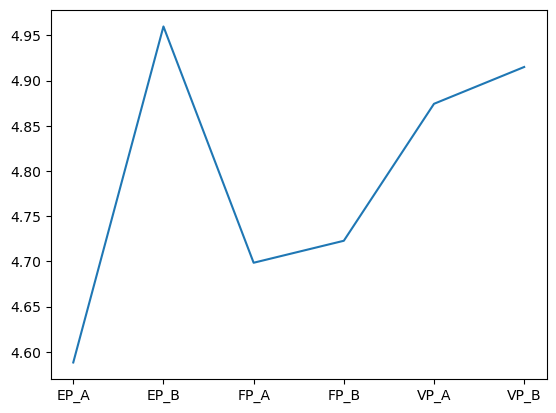

In [110]:
swe_mean_by_praktikum_and_welle.mean(axis=0).plot()

In [111]:
list_praktikums[['Praktikum','SWE','geschlecht']].groupby(by=['Praktikum','geschlecht']).agg(['min', 'max', 'mean', 'median', 'std'])

SWE                                        
                           min       max      mean    median       std
Praktikum geschlecht                                                  
1         0           2.800000  5.600000  4.547619  4.733334  0.790620
          1           2.333333  5.800000  4.652083  4.733334  0.833997
          2           3.600000  3.600000  3.600000  3.600000       NaN
2         0           3.000000  6.000000  5.066007  5.200000  0.702408
          1           3.333333  6.000000  4.908208  4.999999  0.639948
          2           3.666667  4.400000  4.033333  4.033333  0.518545
3         0           2.666667  6.000000  4.925333  5.000000  0.720373
          1           2.800000  6.000000  4.830022  5.000000  0.737511
          2           4.000000  5.400000  4.666667  4.600000  0.702377
4         0           2.666667  6.000000  4.751852  4.900000  0.653764
          1           3.000000  6.000000  4.788021  5.000000  0.704910
          2                NaN       NaN       NaN       NaN       NaN
5         0           2.600000  6.000000  4.801449  4.999999  0.669990
          1           3.000000  6.000000  4.810628  4.800000  0.675525
          2           4.600000  4.600000  4.600000  4.600000       NaN
6         0           3.600000  6.000000  4.942857  5.000000  0.690958
          1           2.333333  6.000000  4.877401  5.000000  0.778484
          2           1.000000  5.666667  3.822222  4.800000  2.482233

In [112]:
list_praktikums[['Praktikum','SWE',]].groupby(by=['Praktikum',]).agg(['min', 'max', 'mean', 'median', 'std'])

SWE                                   
                min  max      mean    median       std
Praktikum                                             
1          2.333333  5.8  4.598581  4.666667  0.818446
2          3.000000  6.0  4.956435  5.000000  0.666651
3          2.666667  6.0  4.853333  5.000000  0.729891
4          2.666667  6.0  4.783970  4.999999  0.692563
5          2.600000  6.0  4.807207  4.800000  0.670673
6          1.000000  6.0  4.871795  5.000000  0.814969

In [113]:
list_praktikums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1079 entries, 0 to 1078
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Welle         1079 non-null   int64   
 1   alter         1047 non-null   float32 
 2   geschlecht    1076 non-null   category
 3   Semester      1049 non-null   float32 
 4   Praktikum     1079 non-null   int64   
 5   P_Absolviert  1079 non-null   int64   
 6   Schultyp_A    1073 non-null   object  
 7   Schultyp_B    22 non-null     object  
 8   LG_B          1079 non-null   float32 
 9   LG_FVP_PD     880 non-null    float32 
 10  LG_FVP_RE     880 non-null    float32 
 11  SWE_01        1079 non-null   float32 
 12  SWE_02        1079 non-null   float32 
 13  SWE_03        1079 non-null   float32 
 14  SWE_04        1079 non-null   float32 
 15  SWE_05        1079 non-null   float32 
 16  SWE           1079 non-null   float32 
 17  F_01          1079 non-null   float32 
 18  F_03    

In [114]:
# lists_w1_to_w8 = pd.concat([
#     w1_[SELECTED_COLUMNS_ALL],
#     w3_[SELECTED_COLUMNS_ALL],
#     w4_[SELECTED_COLUMNS_ALL],
#     w5_[SELECTED_COLUMNS_ALL],
#     w6_[SELECTED_COLUMNS_ALL],
#     w8_[SELECTED_COLUMNS_ALL],
#     ],axis=0)


date = datetime.now()
op = '%s_%s_%s' % ( date.day, date.month, date.year)

DIR = './NEW_LISTS_DECEMBER/'
NAME_FILE = 'lists_w1_to_w6_COMPLETE'

list_praktikums.reset_index(drop=True).to_csv(f"{DIR}{NAME_FILE}{op}.csv", index=False)
pyreadstat.write_sav(pd.read_csv(f"{DIR}{NAME_FILE}{op}.csv"), f"{DIR}{NAME_FILE}{op}.sav")



<Axes: >

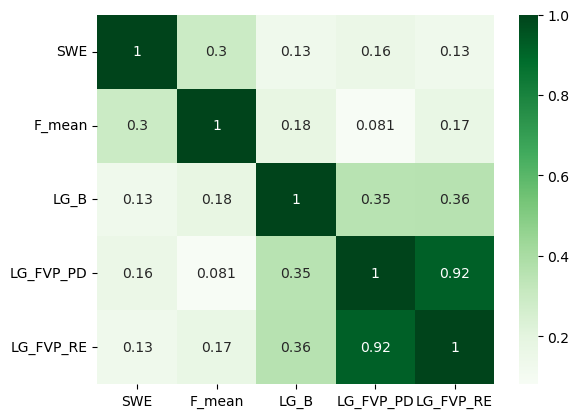

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

matrix = list_praktikums[['SWE','F_mean','LG_B','LG_FVP_PD', 'LG_FVP_RE']].corr()
sns.heatmap(matrix, cmap="Greens", annot=True)

In [117]:
list_praktikums.dtypes

Welle              int64
alter            float32
geschlecht      category
Semester         float32
Praktikum          int64
P_Absolviert       int64
Schultyp_A        object
Schultyp_B        object
LG_B             float32
LG_FVP_PD        float32
LG_FVP_RE        float32
SWE_01           float32
SWE_02           float32
SWE_03           float32
SWE_04           float32
SWE_05           float32
SWE              float32
F_01             float32
F_03             float32
F_09             float32
F_11             float32
F_mean           float32
Imp_FachA        float32
Imp_FachB        float32
FachA             object
FachB             object
dtype: object

/Users/eduardohdz/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 700x3000 with 0 Axes>

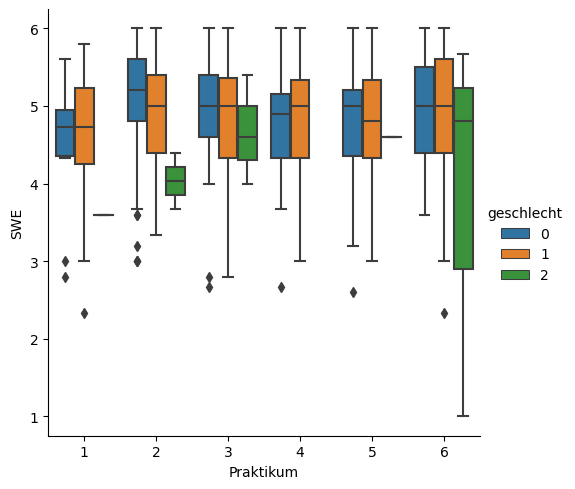

In [118]:
plt.figure(figsize=(7, 30))
sns.catplot(data=list_praktikums[['Praktikum','SWE','geschlecht']], x="Praktikum", y="SWE", hue="geschlecht", kind="box")
plt.show()

/Users/eduardohdz/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


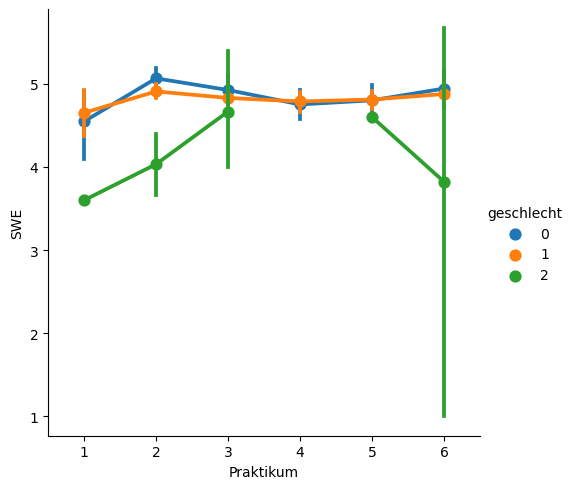

In [119]:
sns.catplot(data=list_praktikums[['Praktikum','SWE','geschlecht']], x="Praktikum", y="SWE", hue="geschlecht", kind="point")

In [120]:
STOP

NameError: name 'STOP' is not defined

In [127]:
w1_stats = w1[['SWE_01','SWE_02','SWE_03','SWE_04','SWE_05']].describe().T.reset_index()
w3_stats = w3[['SWE_01','SWE_02','SWE_03','SWE_04','SWE_05']].describe().T.reset_index()
w4_stats = w4[['SWE_01','SWE_02','SWE_03','SWE_04','SWE_05']].describe().T.reset_index()
w5_stats = w5[['SWE_01','SWE_02','SWE_03','SWE_04','SWE_05']].describe().T.reset_index()
w6_stats = w6[['SWE_01','SWE_02','SWE_03','SWE_04','SWE_05']].describe().T.reset_index()

w1_stats['Welle'] = "W1"
w3_stats['Welle'] = "W3"
w4_stats['Welle'] = "W4"
w5_stats['Welle'] = "W5"
w6_stats['Welle'] = "W6"

stats = pd.concat([w1_stats, w3_stats, w4_stats, w5_stats, w6_stats])
stats.rename(index={"index": "Frage"}, inplace=True)
stats.set_index(['Welle',"index"], inplace=True)


In [128]:
stats


count      mean       std       min       25%       50%  \
Welle index                                                             
W1    SWE_01  187.0  5.028520  1.018535  1.000000  4.333333  4.333333   
      SWE_02  187.0  4.841354  1.034253  2.666667  4.333333  4.333333   
      SWE_03  187.0  4.155080  1.269182  1.000000  2.666667  4.333333   
      SWE_04  187.0  5.028520  1.003765  2.666667  4.333333  4.333333   
      SWE_05  187.0  4.975044  1.038952  2.666667  4.333333  4.333333   
W3    SWE_01   89.0  4.576779  1.219335  1.000000  4.333333  4.333333   
      SWE_02   89.0  4.707865  1.224559  1.000000  4.333333  4.333333   
      SWE_03   89.0  4.127341  1.325266  1.000000  2.666667  4.333333   
      SWE_04   89.0  4.838951  1.189296  1.000000  4.333333  4.333333   
      SWE_05   89.0  4.726592  1.205587  1.000000  4.333333  4.333333   
W4    SWE_01  206.0  5.077670  1.085208  1.000000  4.333333  6.000000   
      SWE_02  206.0  5.150486  1.037774  1.000000  4.333333  6.000000   
      SWE_03  206.0  4.398058  1.150524  1.000000  4.333333  4.333333   
      SWE_04  206.0  5.134304  0.997439  1.000000  4.333333  6.000000   
      SWE_05  206.0  5.021035  1.079039  1.000000  4.333333  4.333333   
W5    SWE_01  112.0  4.964286  0.826679  3.000000  4.750000  5.000000   
      SWE_02  112.0  5.000000  0.794123  2.000000  4.750000  5.000000   
      SWE_03  112.0  4.205357  1.083358  1.000000  4.000000  4.000000   
      SWE_04  112.0  4.803571  0.908809  2.000000  4.000000  5.000000   
      SWE_05  112.0  4.785714  1.017226  2.000000  4.000000  5.000000   
W6    SWE_01  485.0  5.012371  0.897570  1.000000  5.000000  5.000000   
      SWE_02  485.0  5.008247  0.970607  1.000000  5.000000  5.000000   
      SWE_03  485.0  4.391753  1.049958  1.000000  4.000000  4.000000   
      SWE_04  485.0  5.024742  0.883391  2.000000  5.000000  5.000000   
      SWE_05  485.0  5.065979  0.881267  1.000000  5.000000  5.000000   

                   75%  max  
Welle index                  
W1    SWE_01  6.000000  6.0  
      SWE_02  6.000000  6.0  
      SWE_03  4.333333  6.0  
      SWE_04  6.000000  6.0  
      SWE_05  6.000000  6.0  
W3    SWE_01  6.000000  6.0  
      SWE_02  6.000000  6.0  
      SWE_03  4.333333  6.0  
      SWE_04  6.000000  6.0  
      SWE_05  6.000000  6.0  
W4    SWE_01  6.000000  6.0  
      SWE_02  6.000000  6.0  
      SWE_03  4.333333  6.0  
      SWE_04  6.000000  6.0  
      SWE_05  6.000000  6.0  
W5    SWE_01  6.000000  6.0  
      SWE_02  6.000000  6.0  
      SWE_03  5.000000  6.0  
      SWE_04  5.000000  6.0  
      SWE_05  5.000000  6.0  
W6    SWE_01  6.000000  6.0  
      SWE_02  6.000000  6.0  
      SWE_03  5.000000  6.0  
      SWE_04  6.000000  6.0  
      SWE_05  6.000000  6.0